In [685]:
import pandas as pd 
from optbinning import OptimalBinning
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [686]:
df = pd.read_csv('gen_data.csv')

### Tính đầy đủ 

In [687]:
pd.set_option('display.max_rows', None)

Tỷ lệ missing theo cột

In [688]:
missing_col = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_pct': df.isna().mean() * 100
}).sort_values('missing_pct', ascending=False)

missing_col

,missing_count,missing_pct
SOCIF,0,0.00
PURCOD_MIN,0,0.00
FLAG_DEPOSIT,0,0.00
CBAL_SHORTTERM_LOAN,0,0.00
CBAL_LONGTERM_LOAN,0,0.00
HAS_SHORTTERM_LOAN,0,0.00
HAS_LONGTERM_LOAN,0,0.00
DURATION_MAX,0,0.00
REMAINING_DURATION_MAX,0,0.00
TIME_TO_OP_MAX,0,0.00


In [689]:
pd.set_option('display.max_rows', 20)

Tỷ lệ missing theo row

In [690]:
df['ROW_MISSING_PCT'] = df.isna().mean(axis=1) * 100

df['ROW_MISSING_PCT'].describe()

count   1,138,327.00
mean            0.00
std             0.00
min             0.00
25%             0.00
50%             0.00
75%             0.00
max             0.00
Name: ROW_MISSING_PCT, dtype: float64

In [691]:
df['FLAG_HIGH_MISSING'] = (df['ROW_MISSING_PCT'] > 40).astype(int)

### Tính duy nhất 

Trùng khóa logic (SOCIF – year)

In [692]:
dup_key = df.duplicated(subset=['SOCIF', 'year'], keep=False)

df.loc[dup_key].shape

(0, 52)

Trùng toàn bộ bản ghi (record duplicate)

In [693]:
dup_full = df.duplicated(keep=False)

dup_full.sum()


np.int64(0)

In [694]:
dup_rate = dup_full.mean() * 100
print(f"Tỷ lệ bản ghi trùng lặp: {dup_rate:.2f}%")


Tỷ lệ bản ghi trùng lặp: 0.00%


### Tính kịp thời 

Check dùng future information (leakage)

In [695]:
# BAD_NEXT_12M chỉ được missing ở năm cuối
leak_check = df[
    (df['year'] < df['year'].max()) &
    (df['BAD_NEXT_12M'].isna())
]

leak_check.shape


(0, 52)

Check continuity theo năm

In [696]:
year_count = df.groupby('year')['SOCIF'].nunique()
year_count


year
2018    200349
2019    204636
2020    155962
2021    160198
2022    206838
2023    210344
Name: SOCIF, dtype: int64

### Tính phù hợp 

In [697]:
rule_valid_age = (
    df['TUOI'].between(0, 120)
)

df.loc[~rule_valid_age].shape


(0, 52)

In [698]:
rule_valid_ltv = df['LTV'].between(0, 400)

df.loc[~rule_valid_ltv].shape


(0, 52)

In [699]:
rule_valid_duration = (
    (df['DURATION_MAX'] >= 0) &
    (df['REMAINING_DURATION_MAX'] >= 0)
)

df.loc[~rule_valid_duration].shape


(0, 52)

In [700]:
valid_gender = df['C_GIOITINH'].isin(['M', 'F', 'O'])
df.loc[~valid_gender].shape


(0, 52)

In [701]:
df['FLAG_INVALID'] = ~(
    rule_valid_age &
    rule_valid_ltv &
    rule_valid_duration &
    valid_gender
)


In [702]:
pd.set_option('display.max_columns', None)

In [703]:
df.describe()

,SOCIF,TRINHDO,SOHUUNHA,NHANVIENBIDV,INHERENT_RISK,year,BASE_AUM,CURRENT_RISK,TUOI,INCOME,CBAL,CBALORG,AFLIMT_MAX,AFLIMT_MIN,AFLIMT_AVG,CBAL_AVG,CBAL_MAX,CBAL_MIN,COLLATERAL_VALUE,LTV,N_AVG_DEPOSIT_12M,N_AVG_DEPOSIT_6M,N_AVG_DD_12M,N_AVG_CD_12M,FLAG_SALARY_ACC,FLAG_DEPOSIT,CBAL_SHORTTERM_LOAN,CBAL_LONGTERM_LOAN,HAS_SHORTTERM_LOAN,HAS_LONGTERM_LOAN,DURATION_MAX,REMAINING_DURATION_MAX,TIME_TO_OP_MAX,RATE_AVG,PURCOD_MAX,PURCOD_MIN,MAX_DPD_12M,MAX_DPD_12M_OBS,AVG_OD_DPD_12M,SUM_ALL_OD_12M,BAD_CURRENT,XULYNO,MAX_NHOMNOCIC,N_AVG_OVERDUE_CBAL_12M,CBAL_TO_INC_12MON,REAL_GDP_GROWTH_12M,BAD_NEXT_12M,ROW_MISSING_PCT,FLAG_HIGH_MISSING
count,"1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00","1,138,327.00"
mean,"1,199,961.60",1.96,0.37,0.01,-0.45,"2,020.53","15,577,392.66",-0.42,38.73,"24,644,597.89","356,585,070.48","392,278,108.46","771,166,906.92","694,050,215.77","732,608,561.09","356,515,468.90","428,407,616.71","285,212,374.72","752,532,209.87",132.67,"5,598,486.30","5,598,486.30","1,119,696.86","4,478,789.44",0.91,0.83,"178,116,568.63","178,468,501.85",1.00,1.00,91.39,47.52,43.87,8.21,4.60,4.60,24.39,24.39,6.86,48.34,0.00,0.00,1.62,"166,507,333.69",14.42,5.66,0.12,0.00,0.00
std,"115,440.68",0.82,0.48,0.10,0.61,1.77,"22,781,955.16",0.76,9.69,"10,337,725.44","253,432,718.91","280,044,694.87","357,276,408.51","321,548,767.66","339,412,588.09","258,218,905.26","310,051,887.44","206,575,124.21","967,671,702.03",88.01,"9,899,404.16","9,899,404.16","1,979,880.83","7,919,523.32",0.28,0.38,"178,836,718.92","178,708,929.60",0.00,0.00,66.65,44.66,42.11,2.02,2.54,2.54,24.04,24.04,8.19,52.00,0.00,0.00,0.49,"130,535,861.52",7.53,2.03,0.33,0.00,0.00
min,"1,000,000.00",1.00,0.00,0.00,-1.41,"2,018.00","49,727.00",-3.45,18.00,"8,434,659.00","200,882.00","237,960.00","240,489,089.00","216,440,180.00","228,464,634.00","221,060.00","265,272.00","176,848.00","39,781.00",0.03,"13,278.00","13,278.00","2,655.00","10,623.00",0.00,0.00,9.00,28.00,1.00,1.00,6.00,0.00,1.00,5.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2.58,0.00,0.00,0.00
25%,"1,100,216.00",1.00,0.00,0.00,-0.91,"2,019.00","4,345,251.00",-0.95,32.00,"18,148,954.50","187,436,063.50","205,614,280.00","546,773,025.50","492,095,722.50","519,434,373.50","184,988,652.50","222,429,275.50","147,990,921.50","4,771,108.00",20.22,"1,350,469.50","1,350,469.50","270,093.50","1,080,376.00",1.00,1.00,"58,739,301.00","58,954,187.50",1.00,1.00,36.00,17.00,15.00,6.70,2.00,2.00,5.00,5.00,1.00,8.00,0.00,0.00,1.00,"83,059,301.50",8.75,2.91,0.00,0.00,0.00
50%,"1,199,889.00",2.00,0.00,0.00,-0.57,"2,021.00","8,787,907.00",-0.47,39.00,"22,166,739.00","293,442,580.00","322,339,312.00","682,666,499.00","614,399,849.00","648,533,174.00","291,110,424.00","349,895,246.00","232,888,339.00","14,826,793.00",200.00,"2,838,993.00","2,838,993.00","567,798.00","2,271,195.00",1.00,1.00,"127,646,860.00","128,123,248.00",1.00,1.00,60.00,31.00,29.00,8.11,6.00,6.00,16.00,16.00,4.00,29.00,0.00,0.00,2.00,"138,681,626.00",13.05,7.02,0.00,0.00,0.00
75%,"1,299,960.00",2.00,1.00,0.00,-0.11,"2,022.00","18,020,020.50",0.05,45.00,"27,198,264.00","450,082,570.00","495,113,255.00","873,329,773.50","785,996,796.00","829,663,284.50","449,965,528.00","540,671,852.00","359,972,422.00","2,005,339,463.00",200.00,"6,083,645.00","6,083,645.00","1,216,729.00","4,866,916.00",1.00,1.00,"23

In [704]:
pd.set_option('display.max_columns', 20)

In [705]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138327 entries, 0 to 1138326
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SOCIF                   1138327 non-null  int64  
 1   C_GIOITINH              1138327 non-null  object 
 2   TRINHDO                 1138327 non-null  int64  
 3   TTHONNHAN               1138327 non-null  object 
 4   SOHUUNHA                1138327 non-null  int64  
 5   NHANVIENBIDV            1138327 non-null  int64  
 6   INHERENT_RISK           1138327 non-null  float64
 7   year                    1138327 non-null  int64  
 8   BASE_AUM                1138327 non-null  int64  
 9   CURRENT_RISK            1138327 non-null  float64
 10  TUOI                    1138327 non-null  int64  
 11  INCOME                  1138327 non-null  int64  
 12  CBAL                    1138327 non-null  int64  
 13  CBALORG                 1138327 non-null  int64  
 14  AF

In [706]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    print(f"\n{'='*20} {col} {'='*20}")
    vc = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False) * 100
    print(pd.concat([vc, pct.rename('pct_%')], axis=1))


==================== C_GIOITINH ====================
             count  pct_%
C_GIOITINH               
F           560397  49.23
M           555439  48.79
O            22491   1.98

==================== TTHONNHAN ====================
            count  pct_%
TTHONNHAN               
Married    596357  52.39
Single     541970  47.61

==================== SAMPLE_TYPE ====================
              count  pct_%
SAMPLE_TYPE               
TRAIN        721145  63.35
OOT          210344  18.48
OOS          206838  18.17


### Tính chính xác

Tuổi khách hàng

In [707]:
rule_acc_age = df['TUOI'] >= 15

LTV thực tế

In [708]:
rule_acc_ltv = df['LTV'] < 400

Hạn mức – dư nợ

In [709]:
rule_acc_limit = df['AFLIMT_MAX'] >= df['CBAL']

Thu nhập – dư nợ

In [710]:
rule_acc_dti = df['CBAL'] <= df['INCOME'] * 20

CIC – DPD

In [711]:
rule_acc_cic = ~(
    (df['MAX_DPD_12M_OBS'] < 30) & (df['MAX_NHOMNOCIC'] > 1)
) & ~(
    (df['MAX_DPD_12M_OBS'] >= 90) & (df['MAX_NHOMNOCIC'] < 3)
)

Flag & tỷ lệ chính xác

In [712]:
df['FLAG_INACCURATE'] = ~(
    rule_acc_age &
    rule_acc_ltv &
    rule_acc_limit &
    rule_acc_dti &
    rule_acc_cic
)

accuracy_rate = 1 - df['FLAG_INACCURATE'].mean()
accuracy_rate

np.float64(0.565352486587773)

In [713]:
rule_acc_age.sum()

np.int64(1138327)

In [714]:
rule_acc_ltv.sum()

np.int64(1138327)

In [715]:
rule_acc_dti.sum()

np.int64(903090)

In [716]:
rule_acc_cic.sum()

np.int64(810097)

### Tính đồng nhất

CBAL vs cấu trúc kỳ hạn

In [717]:
# rule_cons_balance = (
#     df['CBAL'] ==
#     df['CBAL_SHORTTERM_LOAN']
#     + df['CBAL_MIDTERM_LOAN']
#     + df['CBAL_LONGTERM_LOAN']
# )

# df.loc[~rule_cons_balance].shape

Deposit breakdown

In [718]:
rule_cons_deposit = (
    abs(
        df['N_AVG_DEPOSIT_12M'] -
        (df['N_AVG_DD_12M'] + df['N_AVG_CD_12M'])
    ) <= 1
)
df.loc[~rule_cons_deposit].shape

(0, 54)

DPD logic

In [719]:
rule_cons_dpd = df['MAX_DPD_12M_OBS'] <= df['MAX_DPD_12M']

df.loc[~rule_cons_dpd].shape


(0, 54)

Flag tổng hợp consistency

In [720]:
df['FLAG_INCONSISTENT'] = ~(
    # rule_cons_balance &
    rule_cons_deposit &
    rule_cons_dpd
)

BẢNG TỔNG HỢP (RẤT NÊN CÓ)

In [721]:
quality_summary = pd.DataFrame({
    'Metric': [
        'Completeness',
        'Uniqueness',
        'Timeliness',
        'Validity',
        'Accuracy',
        'Consistency'
    ],
    'Issue_Rate_%': [
        df['FLAG_HIGH_MISSING'].mean() * 100,
        dup_full.mean() * 100,
        leak_check.shape[0] / len(df) * 100,
        df['FLAG_INVALID'].mean() * 100,
        df['FLAG_INACCURATE'].mean() * 100,
        df['FLAG_INCONSISTENT'].mean() * 100
    ]
})

quality_summary

,Metric,Issue_Rate_%
0,Completeness,0.00
1,Uniqueness,0.00
2,Timeliness,0.00
3,Validity,0.00
4,Accuracy,43.46
5,Consistency,0.00


In [722]:
df['FLAG_AGE_INVALID'] = (~rule_acc_age).astype(int)
df['FLAG_LTV_HIGH']    = (~rule_acc_ltv).astype(int)
df['FLAG_DTI_HIGH']    = (~rule_acc_dti).astype(int)
df['FLAG_CIC_LOW']     = (~rule_acc_cic).astype(int)
# df['FLAG_INCONSISTENT_DEPOSIT'] = (~rule_cons_deposit).astype(int)

In [723]:
import numpy as np

In [724]:
flag_cols = [c for c in df.columns if c.startswith('FLAG_')]

dq_flag_impact = []

for c in flag_cols:
    tmp = df.groupby(c)['BAD_NEXT_12M'].mean()
    dq_flag_impact.append({
        'FLAG': c,
        'BAD_RATE_0': tmp.get(0, np.nan),
        'BAD_RATE_1': tmp.get(1, np.nan),
        'LIFT': tmp.get(1, np.nan) / tmp.get(0, np.nan)
    })

dq_flag_impact = pd.DataFrame(dq_flag_impact).sort_values('LIFT', ascending=False)
dq_flag_impact


,FLAG,BAD_RATE_0,BAD_RATE_1,LIFT
8,FLAG_DTI_HIGH,0.11,0.15,1.29
4,FLAG_INACCURATE,0.14,0.10,0.69
0,FLAG_SALARY_ACC,0.17,0.12,0.66
9,FLAG_CIC_LOW,0.15,0.05,0.36
1,FLAG_DEPOSIT,0.28,0.09,0.31
2,FLAG_HIGH_MISSING,0.12,NaN,NaN
3,FLAG_INVALID,0.12,NaN,NaN
5,FLAG_INCONSISTENT,0.12,NaN,NaN
6,FLAG_AGE_INVALID,0.12,NaN,NaN
7,FLAG_LTV_HIGH,0.12,NaN,NaN


In [725]:
for f in ['FLAG_HIGH_MISSING', 'FLAG_INCONSISTENT']:
    print(f, df[f].value_counts(dropna=False))


FLAG_HIGH_MISSING FLAG_HIGH_MISSING
0    1138327
Name: count, dtype: int64
FLAG_INCONSISTENT FLAG_INCONSISTENT
False    1138327
Name: count, dtype: int64


In [726]:
df.shape

(1138327, 59)

In [727]:
df.drop(['FLAG_DTI_HIGH', 'FLAG_INACCURATE', 'FLAG_CIC_LOW', 'FLAG_HIGH_MISSING', 'FLAG_INCONSISTENT', 'ROW_MISSING_PCT'], axis=1, inplace=True)

In [728]:
df.columns

Index(['SOCIF', 'C_GIOITINH', 'TRINHDO', 'TTHONNHAN', 'SOHUUNHA',
       'NHANVIENBIDV', 'INHERENT_RISK', 'year', 'BASE_AUM', 'CURRENT_RISK',
       'TUOI', 'INCOME', 'CBAL', 'CBALORG', 'AFLIMT_MAX', 'AFLIMT_MIN',
       'AFLIMT_AVG', 'CBAL_AVG', 'CBAL_MAX', 'CBAL_MIN', 'COLLATERAL_VALUE',
       'LTV', 'N_AVG_DEPOSIT_12M', 'N_AVG_DEPOSIT_6M', 'N_AVG_DD_12M',
       'N_AVG_CD_12M', 'FLAG_SALARY_ACC', 'FLAG_DEPOSIT',
       'CBAL_SHORTTERM_LOAN', 'CBAL_LONGTERM_LOAN', 'HAS_SHORTTERM_LOAN',
       'HAS_LONGTERM_LOAN', 'DURATION_MAX', 'REMAINING_DURATION_MAX',
       'TIME_TO_OP_MAX', 'RATE_AVG', 'PURCOD_MAX', 'PURCOD_MIN', 'MAX_DPD_12M',
       'MAX_DPD_12M_OBS', 'AVG_OD_DPD_12M', 'SUM_ALL_OD_12M', 'BAD_CURRENT',
       'XULYNO', 'MAX_NHOMNOCIC', 'N_AVG_OVERDUE_CBAL_12M',
       'CBAL_TO_INC_12MON', 'REAL_GDP_GROWTH_12M', 'BAD_NEXT_12M',
       'SAMPLE_TYPE', 'FLAG_INVALID', 'FLAG_AGE_INVALID', 'FLAG_LTV_HIGH'],
      dtype='object')

In [729]:
df_train = df[df['SAMPLE_TYPE'] == 'TRAIN']
df_train_y = df_train['BAD_NEXT_12M']
df_OOS = df[df['SAMPLE_TYPE'] == 'OOS']
df_OOS_y = df_OOS['BAD_NEXT_12M']
df_OOT = df[df['SAMPLE_TYPE'] == 'OOT']
df_OOT_y = df_OOT['BAD_NEXT_12M']

In [730]:
df_train.drop(['SAMPLE_TYPE','BAD_NEXT_12M'], axis=1, inplace=True)
df_OOS.drop(['SAMPLE_TYPE', 'BAD_NEXT_12M'], axis=1, inplace=True)
df_OOT.drop(['SAMPLE_TYPE', 'BAD_NEXT_12M'], axis=1, inplace=True)

In [731]:
df_train.columns

Index(['SOCIF', 'C_GIOITINH', 'TRINHDO', 'TTHONNHAN', 'SOHUUNHA',
       'NHANVIENBIDV', 'INHERENT_RISK', 'year', 'BASE_AUM', 'CURRENT_RISK',
       'TUOI', 'INCOME', 'CBAL', 'CBALORG', 'AFLIMT_MAX', 'AFLIMT_MIN',
       'AFLIMT_AVG', 'CBAL_AVG', 'CBAL_MAX', 'CBAL_MIN', 'COLLATERAL_VALUE',
       'LTV', 'N_AVG_DEPOSIT_12M', 'N_AVG_DEPOSIT_6M', 'N_AVG_DD_12M',
       'N_AVG_CD_12M', 'FLAG_SALARY_ACC', 'FLAG_DEPOSIT',
       'CBAL_SHORTTERM_LOAN', 'CBAL_LONGTERM_LOAN', 'HAS_SHORTTERM_LOAN',
       'HAS_LONGTERM_LOAN', 'DURATION_MAX', 'REMAINING_DURATION_MAX',
       'TIME_TO_OP_MAX', 'RATE_AVG', 'PURCOD_MAX', 'PURCOD_MIN', 'MAX_DPD_12M',
       'MAX_DPD_12M_OBS', 'AVG_OD_DPD_12M', 'SUM_ALL_OD_12M', 'BAD_CURRENT',
       'XULYNO', 'MAX_NHOMNOCIC', 'N_AVG_OVERDUE_CBAL_12M',
       'CBAL_TO_INC_12MON', 'REAL_GDP_GROWTH_12M', 'FLAG_INVALID',
       'FLAG_AGE_INVALID', 'FLAG_LTV_HIGH'],
      dtype='object')

In [732]:
# df_train.to_csv('train.csv', index=False)
# df_OOS.to_csv('oos.csv', index=False)
# df_OOT.to_csv('oot.csv', index=False)

kiểm tra có leakage ko, nếu dùng toàn bộ data để phân khúc kh

In [733]:
segmentation_candidates = [
    # --- NHÓM 1: QUY MÔ & TÀI SẢN (Wealth & Scale) - "Giàu hay Nghèo?" ---
    'BASE_AUM',             # Tổng tài sản (Quan trọng nhất)
    'INCOME',               # Thu nhập
    'COLLATERAL_VALUE',     # Giá trị TSBĐ (Phân biệt vay thế chấp/tín chấp)
    'SOHUUNHA',             # Có nhà hay không
    
    # --- NHÓM 2: QUY MÔ TÍN DỤNG (Exposure) - "Vay nhiều hay ít?" ---
    'AFLIMT_MAX',           # Hạn mức (Sức chứa)
    'CBAL',                 # Dư nợ hiện tại
    'CBAL_MAX',             # Đỉnh nợ
    
    # --- NHÓM 3: SẢN PHẨM & MỤC ĐÍCH (Product) - "Vay để làm gì?" ---
    # (MỚI BỔ SUNG - Rất quan trọng để tách Portfolio)
    'PURCOD_MAX',           # Mã mục đích vay (BĐS, Tiêu dùng, SXKD...)
    'HAS_SHORTTERM_LOAN',   # Chỉ vay ngắn hạn?
    'HAS_LONGTERM_LOAN',    # Có vay dài hạn?
    'DURATION_MAX',         # Kỳ hạn vay (Ngắn/Trung/Dài)
    
    # --- NHÓM 4: THANH KHOẢN (Liquidity) - "Có tiền mặt không?" ---
    'N_AVG_DEPOSIT_12M',    # Tiền gửi bình quân
    'FLAG_SALARY_ACC',      # Có trả lương qua đây không?
    'FLAG_DEPOSIT',         # Có tài khoản tiền gửi không?
    
    # --- NHÓM 5: NHÂN KHẨU (Demographics) - "Ai?" ---
    'TUOI',                 # Độ tuổi (Người trẻ rủi ro khác người già)
    'TRINHDO',              # Học vấn
    'TTHONNHAN'             # Hôn nhân
]

X = df[segmentation_candidates].fillna(0)
y = df['BAD_NEXT_12M']

categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns

for col in categorical_cols:
    # Bước 1: Điền giá trị thiếu cho biến chữ trước (nếu có)
    X[col] = X[col].fillna("Unknown")
    
    # Bước 2: Chuyển sang dạng số (0, 1, 2...)
    # Ví dụ: Single -> 0, Married -> 1
    X[col] = X[col].astype('category').cat.codes
    
    print(f" -> Đã mã hóa biến: {col}")
    
# Điền giá trị 0 vào các ô trống (hoặc dùng trung bình tùy nghiệp vụ)
imputer = SimpleImputer(strategy='constant', fill_value=0)                       # ko có null

X_filled = imputer.fit_transform(X)

# 4. Cấu hình Cây quyết định (Theo đúng Báo cáo BIDV)
# criterion='gini', class_weight='balanced'
dt_model = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    class_weight='balanced',
    random_state=42,
    max_depth=5  # Giới hạn độ sâu để tránh overfitting khi tính độ quan trọng
)

# Huấn luyện mô hình
dt_model.fit(X_filled, y)

# 5. Trích xuất Feature Importance
importance_df = pd.DataFrame({
    'Tên Biến': segmentation_candidates,
    'Độ Quan Trọng (Feature Importance)': dt_model.feature_importances_
})

# Sắp xếp từ cao xuống thấp
importance_df = importance_df.sort_values(by='Độ Quan Trọng (Feature Importance)', ascending=False)

print("--- KẾT QUẢ XẾP HẠNG ĐỘ QUAN TRỌNG CỦA BIẾN ---")
print(importance_df)

 -> Đã mã hóa biến: TTHONNHAN
--- KẾT QUẢ XẾP HẠNG ĐỘ QUAN TRỌNG CỦA BIẾN ---
              Tên Biến  Độ Quan Trọng (Feature Importance)
2     COLLATERAL_VALUE                                0.67
11   N_AVG_DEPOSIT_12M                                0.31
0             BASE_AUM                                0.01
5                 CBAL                                0.01
6             CBAL_MAX                                0.00
10        DURATION_MAX                                0.00
15             TRINHDO                                0.00
14                TUOI                                0.00
13        FLAG_DEPOSIT                                0.00
12     FLAG_SALARY_ACC                                0.00
8   HAS_SHORTTERM_LOAN                                0.00
9    HAS_LONGTERM_LOAN                                0.00
1               INCOME                                0.00
7           PURCOD_MAX                                0.00
4           AFLIMT_MAX               

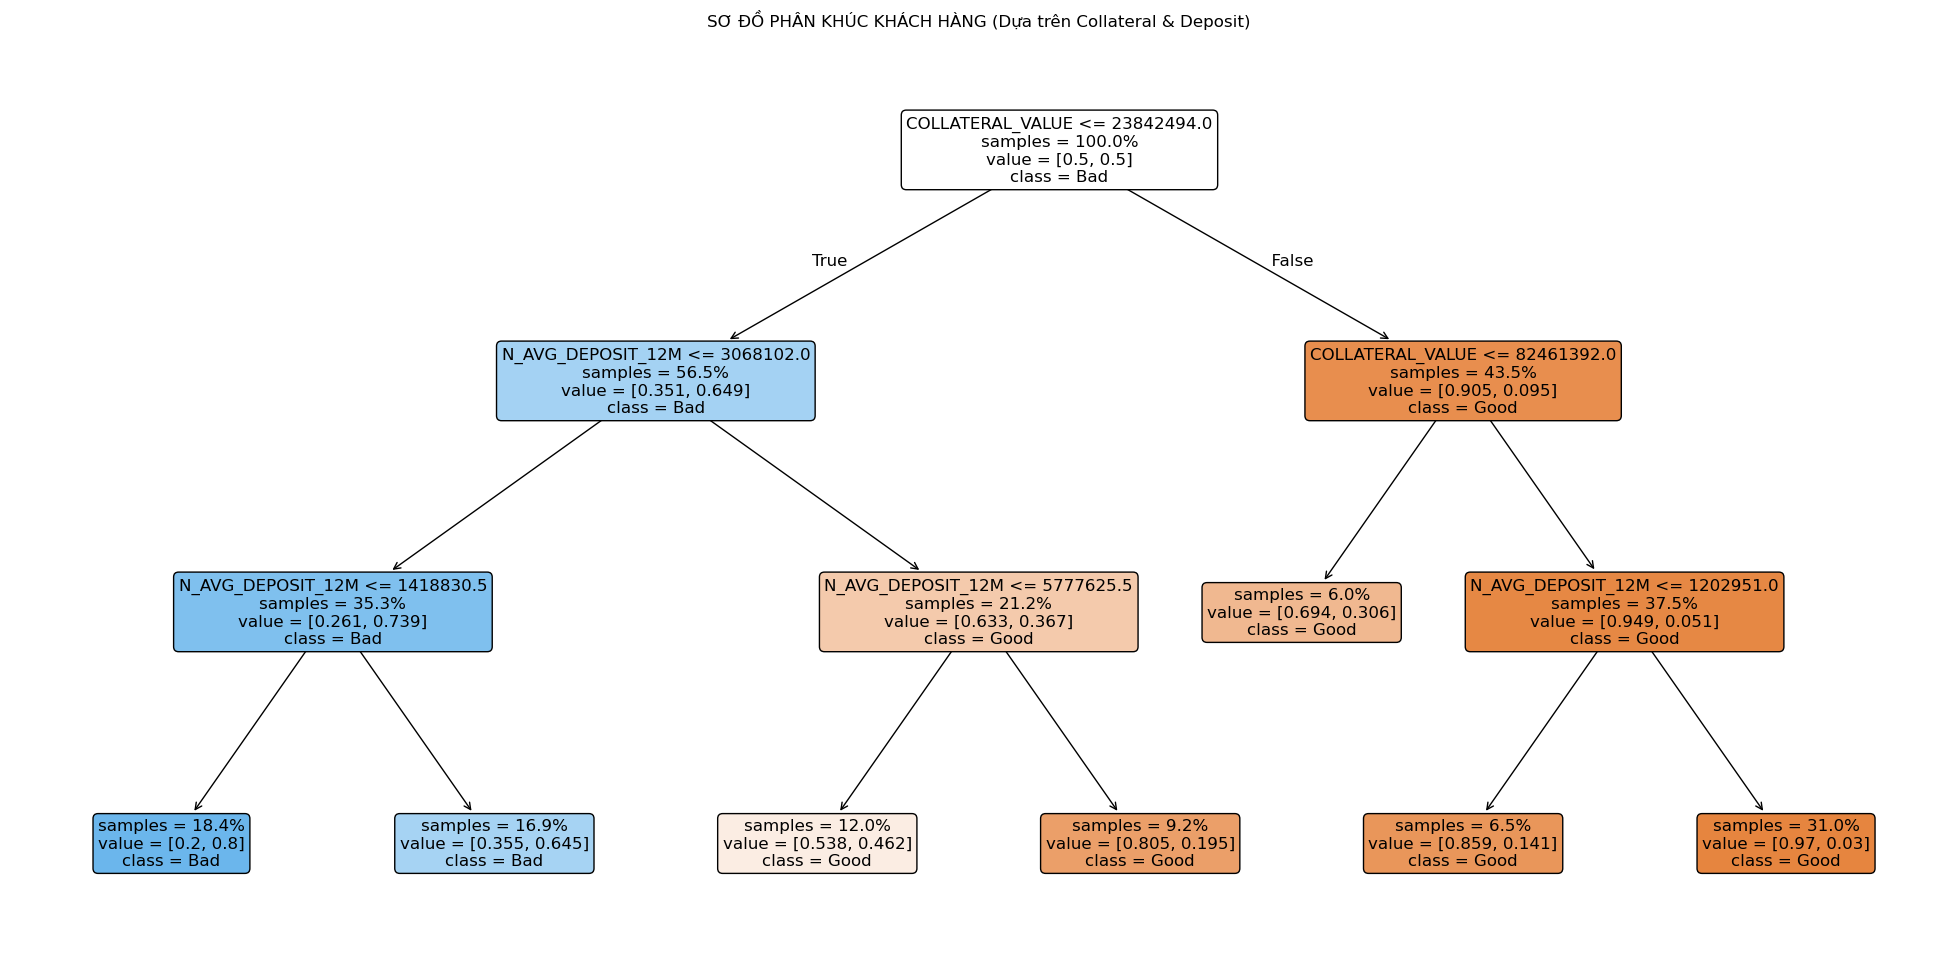

In [734]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Cấu hình lại cây nông hơn (max_depth=3) để dễ nhìn biểu đồ
dt_viz = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=3,            # Chỉ vẽ 3 tầng
    min_samples_leaf=0.05, 
    class_weight='balanced',
    random_state=42
)
dt_viz.fit(X_filled, y)

# Vẽ hình
plt.figure(figsize=(25, 12))
plot_tree(
    dt_viz, 
    feature_names=segmentation_candidates, 
    class_names=['Good', 'Bad'],
    filled=True, 
    rounded=True, 
    fontsize=12,
    impurity=False, # Ẩn chỉ số Gini cho đỡ rối
    proportion=True # Hiển thị tỷ lệ %
)
plt.title("SƠ ĐỒ PHÂN KHÚC KHÁCH HÀNG (Dựa trên Collateral & Deposit)")
plt.show()

In [735]:
# ==========================================
# 11. TÌM NGƯỠNG CẮT TỐI ƯU (OPTIMAL BINNING)
# ==========================================
from optbinning import OptimalBinning
import pandas as pd

print("\n=== TÌM NGƯỠNG CẮT TỐI ƯU (DATA-DRIVEN THRESHOLDS) ===")

# Hàm hỗ trợ tìm điểm cắt
def find_optimal_cutoff(df, feature, target):
    # Cấu hình Optimal Binning
    # max_n_bins=2 -> Chỉ chia làm 2 phần (<= Ngưỡng và > Ngưỡng)
    optb = OptimalBinning(name=feature, dtype="numerical", solver="cp", max_n_bins=2)
    
    # Fit dữ liệu
    optb.fit(df[feature], df[target])
    
    # Lấy bảng kết quả binning
    binning_table = optb.binning_table.build()
    
    # Lấy điểm cắt (Split point)
    # Thường nó nằm ở dòng đầu tiên cột 'Bin' (dạng [-inf, 10000.0))
    splits = optb.splits
    
    print(f"\n--- Phân tích biến: {feature} ---")
    if len(splits) > 0:
        cutoff = splits[0]
        print(f"-> Điểm cắt tối ưu (Math): {cutoff:,.0f}")
        print(f"-> Gợi ý làm tròn (Business): {round(cutoff, -6):,.0f}") # Làm tròn đến hàng triệu
        print("Chi tiết chia nhóm:")
        display(binning_table[['Bin', 'Count', 'Event', 'Non-event', 'Event rate', 'IV']])
        return cutoff
    else:
        print("-> Không tìm thấy điểm cắt tối ưu (Biến này không phân tách được rủi ro).")
        return None

# 1. Tìm ngưỡng cho TÀI SẢN ĐẢM BẢO (Collateral)
# Để tách nhóm Secured vs Unsecured
cutoff_collateral = find_optimal_cutoff(df, 'COLLATERAL_VALUE', 'BAD_NEXT_12M')

# 2. Tìm ngưỡng cho TIỀN GỬI (Deposit)
# Để tách nhóm VIP vs Mass (Chỉ chạy trên tập KHÔNG có TSBĐ để chuẩn bài)
# Vì nhóm có TSBĐ đã tách ra rồi, ta chỉ quan tâm phân khúc VIP trong nhóm Tín chấp
df_unsecured = df[df['COLLATERAL_VALUE'] <= (cutoff_collateral if cutoff_collateral else 0)]
cutoff_deposit = find_optimal_cutoff(df_unsecured, 'N_AVG_DEPOSIT_12M', 'BAD_NEXT_12M')

# ==========================================
# CẬP NHẬT LẠI BIẾN CẮT (Nếu muốn dùng số máy tính)
# ==========================================
# THRESH_COLLATERAL = cutoff_collateral
# THRESH_DEPOSIT = cutoff_deposit


=== TÌM NGƯỠNG CẮT TỐI ƯU (DATA-DRIVEN THRESHOLDS) ===

--- Phân tích biến: COLLATERAL_VALUE ---
-> Điểm cắt tối ưu (Math): 2,001,607,488
-> Gợi ý làm tròn (Business): 2,002,000,000
Chi tiết chia nhóm:


,Bin,Count,Event,Non-event,Event rate,IV
0,"(-inf, 2001607488.00)",739123,134530,604593,0.18,0.18
1,"[2001607488.00, inf)",399204,2513,396691,0.01,1.16
2,Special,0,0,0,0.00,0.00
3,Missing,0,0,0,0.00,0.00
Totals,,1138327,137043,1001284,0.12,1.34



--- Phân tích biến: N_AVG_DEPOSIT_12M ---
-> Điểm cắt tối ưu (Math): 3,332,957
-> Gợi ý làm tròn (Business): 3,000,000
Chi tiết chia nhóm:


,Bin,Count,Event,Non-event,Event rate,IV
0,"(-inf, 3332957.00)",446621,116307,330314,0.26,0.15
1,"[3332957.00, inf)",292502,18223,274279,0.06,0.38
2,Special,0,0,0,0.00,0.00
3,Missing,0,0,0,0.00,0.00
Totals,,739123,134530,604593,0.18,0.53


In [736]:
# ==========================================
# 12. CHỐT PHÂN KHÚC (FINAL SEGMENTATION)
# ==========================================
print("\n=== ÁP DỤNG NGƯỠNG CẮT ĐỂ CHIA 3 PHÂN KHÚC ===")

# 1. Định nghĩa ngưỡng (Làm tròn từ kết quả Optimal Binning)
THRESH_COLLATERAL = 2_000_000_000  # 2 Tỷ VND
THRESH_DEPOSIT    = 3_500_000      # 3.5 Triệu VND

print(f"-> Ngưỡng TSBĐ: {THRESH_COLLATERAL:,.0f} VND")
print(f"-> Ngưỡng Tiền gửi: {THRESH_DEPOSIT:,.0f} VND")

# 2. Gán nhãn Phân khúc
conditions = [
    # Nhóm 1: RICH / SECURED (Có TSBĐ lớn hơn 2 tỷ) -> Rủi ro cực thấp (0.6%)
    (df['COLLATERAL_VALUE'] >= THRESH_COLLATERAL),
    
    # Nhóm 2: PRIME UNSECURED (Không TSBĐ lớn, nhưng có tiền gửi > 3.5tr) -> Rủi ro vừa (6%)
    (df['COLLATERAL_VALUE'] < THRESH_COLLATERAL) & (df['N_AVG_DEPOSIT_12M'] >= THRESH_DEPOSIT),
    
    # Nhóm 3: SUBPRIME / MASS (Không TSBĐ lớn, tiền gửi ít < 3.5tr) -> Rủi ro cao (26%)
    (df['COLLATERAL_VALUE'] < THRESH_COLLATERAL) & (df['N_AVG_DEPOSIT_12M'] < THRESH_DEPOSIT)
]

choices = ['1. Rich/Secured', '2. Prime Unsecured', '3. Mass Unsecured']

df['SEGMENT'] = np.select(conditions, choices, default='Unknown')

# 3. Kiểm tra kết quả lần cuối
print("\n--- HIỆU QUẢ PHÂN KHÚC (SEGMENT PERFORMANCE) ---")
summary = df.groupby('SEGMENT').agg({
    'SOCIF': 'count',
    'BAD_NEXT_12M': 'mean',
    'CBAL': 'mean',
    'INCOME': 'mean',
    'COLLATERAL_VALUE': 'mean'
}).rename(columns={
    'SOCIF': 'Số lượng KH',
    'BAD_NEXT_12M': 'Bad Rate',
    'CBAL': 'Dư nợ TB',
    'INCOME': 'Thu nhập TB',
    'COLLATERAL_VALUE': 'TSBĐ TB'
})

pd.options.display.float_format = '{:,.2f}'.format
print(summary)

# 4. Tách DataFrame để chuẩn bị cho bước Modeling tiếp theo
df_seg1 = df[df['SEGMENT'] == '1. Rich/Secured'].copy()
df_seg2 = df[df['SEGMENT'] == '2. Prime Unsecured'].copy()
df_seg3 = df[df['SEGMENT'] == '3. Mass Unsecured'].copy()


=== ÁP DỤNG NGƯỠNG CẮT ĐỂ CHIA 3 PHÂN KHÚC ===
-> Ngưỡng TSBĐ: 2,000,000,000 VND
-> Ngưỡng Tiền gửi: 3,500,000 VND

--- HIỆU QUẢ PHÂN KHÚC (SEGMENT PERFORMANCE) ---
                    Số lượng KH  Bad Rate       Dư nợ TB   Thu nhập TB  \
SEGMENT                                                                  
1. Rich/Secured          421221      0.01 370,729,912.97 25,453,784.02   
2. Prime Unsecured       280190      0.06 374,424,901.12 26,552,064.57   
3. Mass Unsecured        436916      0.27 331,507,831.74 22,641,239.61   

                            TSBĐ TB  
SEGMENT                              
1. Rich/Secured    2,014,906,938.46  
2. Prime Unsecured    20,520,361.35  
3. Mass Unsecured      4,936,915.32  


In [737]:
# ==========================================
# 13. TÍNH IV (INFORMATION VALUE) CHO TỪNG PHÂN KHÚC
# ==========================================
import pandas as pd
import numpy as np

def calculate_iv(df, feature, target):
    # Chia bin đơn giản (10 bins) để tính IV nhanh
    try:
        df_bin = pd.DataFrame()
        df_bin['bin'] = pd.qcut(df[feature], q=10, duplicates='drop')
        df_bin['y'] = df[target]
        
        grp = df_bin.groupby('bin')['y'].agg(['count', 'sum'])
        grp['non_event'] = grp['count'] - grp['sum']
        
        # Tránh chia cho 0
        grp['pct_event'] = (grp['sum'] + 0.5) / (grp['sum'].sum() + 0.5)
        grp['pct_non_event'] = (grp['non_event'] + 0.5) / (grp['non_event'].sum() + 0.5)
        
        grp['woe'] = np.log(grp['pct_non_event'] / grp['pct_event'])
        grp['iv'] = (grp['pct_non_event'] - grp['pct_event']) * grp['woe']
        
        return grp['iv'].sum()
    except:
        return 0

# Danh sách biến cần kiểm tra (Bỏ các biến ID và Target)
features_to_check = [
    'BASE_AUM', 'INCOME', 'LTV', 'COLLATERAL_VALUE', 
    'MAX_DPD_12M_OBS', 'CBAL_TO_INC_12MON', 'N_AVG_DEPOSIT_12M',
    'AFLIMT_MAX', 'CBAL'
]

# Chạy vòng lặp cho 3 phân khúc
segments = ['1. Rich/Secured', '2. Prime Unsecured', '3. Mass Unsecured']
results = {}

print("\n=== TOP 5 BIẾN QUAN TRỌNG NHẤT (IV) THEO TỪNG PHÂN KHÚC ===")

for seg in segments:
    df_sub = df[df['SEGMENT'] == seg]
    iv_scores = {}
    for feat in features_to_check:
        iv_scores[feat] = calculate_iv(df_sub, feat, 'BAD_NEXT_12M')
    
    # Sắp xếp và lấy top 5
    top_5 = sorted(iv_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\n🔹 PHÂN KHÚC: {seg} (Bad Rate: {df_sub['BAD_NEXT_12M'].mean():.2%})")
    for feat, iv in top_5:
        strength = "Mạnh" if iv > 0.3 else ("Trung bình" if iv > 0.1 else "Yếu")
        print(f"   - {feat:20} : IV = {iv:.4f} ({strength})")


=== TOP 5 BIẾN QUAN TRỌNG NHẤT (IV) THEO TỪNG PHÂN KHÚC ===

🔹 PHÂN KHÚC: 1. Rich/Secured (Bad Rate: 0.72%)
   - MAX_DPD_12M_OBS      : IV = 4.4595 (Mạnh)
   - N_AVG_DEPOSIT_12M    : IV = 1.5105 (Mạnh)
   - BASE_AUM             : IV = 0.5021 (Mạnh)
   - COLLATERAL_VALUE     : IV = 0.5021 (Mạnh)
   - CBAL_TO_INC_12MON    : IV = 0.3428 (Mạnh)

🔹 PHÂN KHÚC: 2. Prime Unsecured (Bad Rate: 5.93%)
   - MAX_DPD_12M_OBS      : IV = 3.1394 (Mạnh)
   - N_AVG_DEPOSIT_12M    : IV = 0.5916 (Mạnh)
   - CBAL_TO_INC_12MON    : IV = 0.1547 (Trung bình)
   - CBAL                 : IV = 0.1031 (Trung bình)
   - BASE_AUM             : IV = 0.0523 (Yếu)

🔹 PHÂN KHÚC: 3. Mass Unsecured (Bad Rate: 26.87%)
   - MAX_DPD_12M_OBS      : IV = 2.4522 (Mạnh)
   - N_AVG_DEPOSIT_12M    : IV = 0.2449 (Trung bình)
   - BASE_AUM             : IV = 0.0551 (Yếu)
   - COLLATERAL_VALUE     : IV = 0.0551 (Yếu)
   - CBAL_TO_INC_12MON    : IV = 0.0551 (Yếu)


# 3. MASS UNSECURED

--- ĐANG XÂY DỰNG BINNING CHO: 3. Mass Unsecured ---
Số lượng mẫu: 436,916
Bad Rate: 26.87%

Processing: N_AVG_DEPOSIT_12M...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 323174.00)",21873,0.05,11022,10851,0.50,-0.99,0.06,0.01
1,"[323174.00, 485679.00)",24435,0.06,13876,10559,0.43,-0.73,0.03,0.00
2,"[485679.00, 637236.50)",26423,0.06,16235,10188,0.39,-0.54,0.02,0.00
3,"[637236.50, 757959.00)",21855,0.05,13988,7867,0.36,-0.43,0.01,0.00
4,"[757959.00, 953541.50)",35263,0.08,23558,11705,0.33,-0.30,0.01,0.00
5,"[953541.50, 1095946.00)",25517,0.06,17701,7816,0.31,-0.18,0.00,0.00
6,"[1095946.00, 1236614.50)",24376,0.06,17355,7021,0.29,-0.10,0.00,0.00
7,"[1236614.50, 1422102.00)",30425,0.07,22250,8175,0.27,0.00,0.00,0.00
8,"[1422102.00, 1687003.00)",40367,0.09,30471,9896,0.25,0.12,0.00,0.00
9,"[1687003.00, 1842650.00)",21857,0.05,16924,4933,0.23,0.23,0.00,0.00


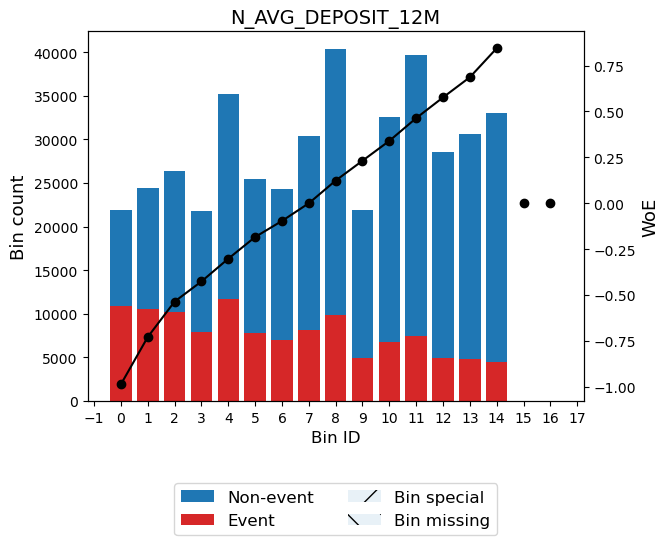


Processing: LTV...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",436916,1.00,319517,117399,0.27,0.00,0.00,0.00
1,Special,0,0.00,0,0,0.00,0.00,0.00,0.00
2,Missing,0,0.00,0,0,0.00,0.00,0.00,0.00
Totals,,436916,1.00,319517,117399,0.27,,0.00,0.00


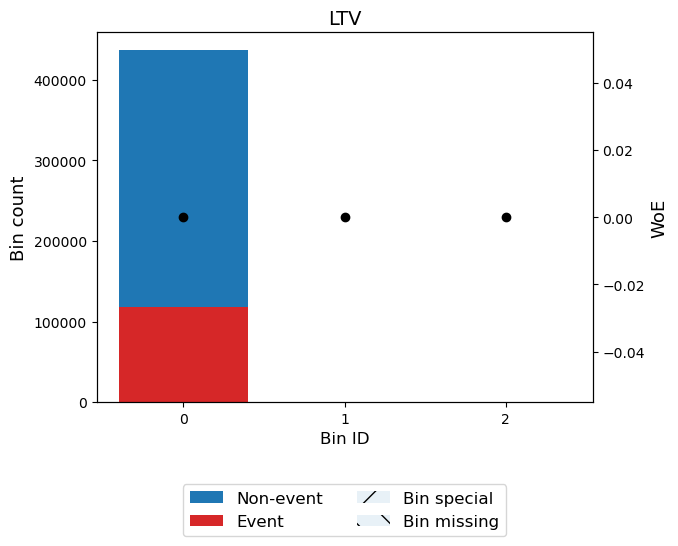


Processing: INCOME...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 13127894.00)",21878,0.05,15266,6612,0.30,-0.16,0.00,0.00
1,"[13127894.00, 14455217.50)",22003,0.05,15710,6293,0.29,-0.09,0.00,0.00
2,"[14455217.50, 15750715.50)",30986,0.07,22263,8723,0.28,-0.06,0.00,0.00
3,"[15750715.50, 18825063.00)",85876,0.20,62280,23596,0.27,-0.03,0.00,0.00
4,"[18825063.00, 20048418.00)",33563,0.08,24446,9117,0.27,-0.01,0.00,0.00
5,"[20048418.00, 20747031.00)",21925,0.05,16096,5829,0.27,0.01,0.00,0.00
6,"[20747031.00, 25354131.00)",114520,0.26,84223,30297,0.26,0.02,0.00,0.00
7,"[25354131.00, 39164536.00)",81634,0.19,60905,20729,0.25,0.08,0.00,0.00
8,"[39164536.00, inf)",24531,0.06,18328,6203,0.25,0.08,0.00,0.00
9,Special,0,0.00,0,0,0.00,0.00,0.00,0.00


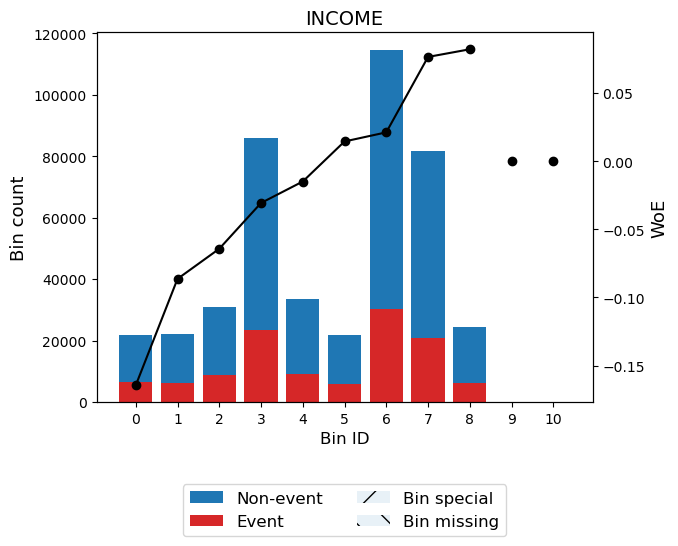


Processing: CBAL_TO_INC_12MON...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.29)",26991,0.06,22486,4505,0.17,0.61,0.02,0.00
1,"[5.29, 6.45)",22932,0.05,18580,4352,0.19,0.45,0.01,0.00
2,"[6.45, 8.00)",37358,0.09,30141,7217,0.19,0.43,0.01,0.00
3,"[8.00, 9.38)",35798,0.08,26109,9689,0.27,-0.01,0.00,0.00
4,"[9.38, 12.53)",79818,0.18,57713,22105,0.28,-0.04,0.00,0.00
5,"[12.53, 14.33)",41341,0.09,29617,11724,0.28,-0.07,0.00,0.00
6,"[14.33, 17.61)",63529,0.15,45203,18326,0.29,-0.10,0.00,0.00
7,"[17.61, 20.17)",38821,0.09,27384,11437,0.29,-0.13,0.00,0.00
8,"[20.17, 23.67)",37492,0.09,26077,11415,0.30,-0.18,0.00,0.00
9,"[23.67, 28.26)",28626,0.07,19776,8850,0.31,-0.20,0.00,0.00


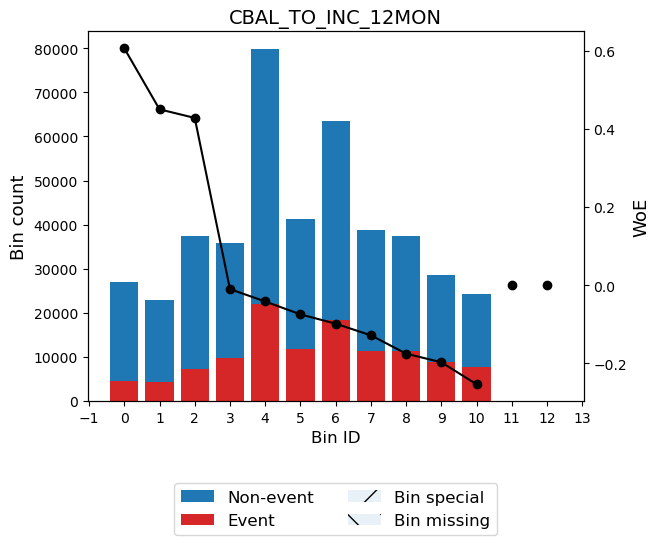


Processing: RATE_AVG...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.50)",41357,0.09,33774,7583,0.18,0.49,0.02,0.00
1,"[5.50, 6.21)",32081,0.07,25225,6856,0.21,0.30,0.01,0.00
2,"[6.21, 6.74)",31967,0.07,24755,7212,0.23,0.23,0.00,0.00
3,"[6.74, 7.10)",24992,0.06,18923,6069,0.24,0.14,0.00,0.00
4,"[7.10, 7.40)",22853,0.05,17209,5644,0.25,0.11,0.00,0.00
5,"[7.40, 7.69)",23513,0.05,17532,5981,0.25,0.07,0.00,0.00
6,"[7.69, 8.18)",40190,0.09,29626,10564,0.26,0.03,0.00,0.00
7,"[8.18, 8.64)",37800,0.09,27678,10122,0.27,0.00,0.00,0.00
8,"[8.64, 9.05)",31883,0.07,22869,9014,0.28,-0.07,0.00,0.00
9,"[9.05, 9.65)",41598,0.10,29389,12209,0.29,-0.12,0.00,0.00


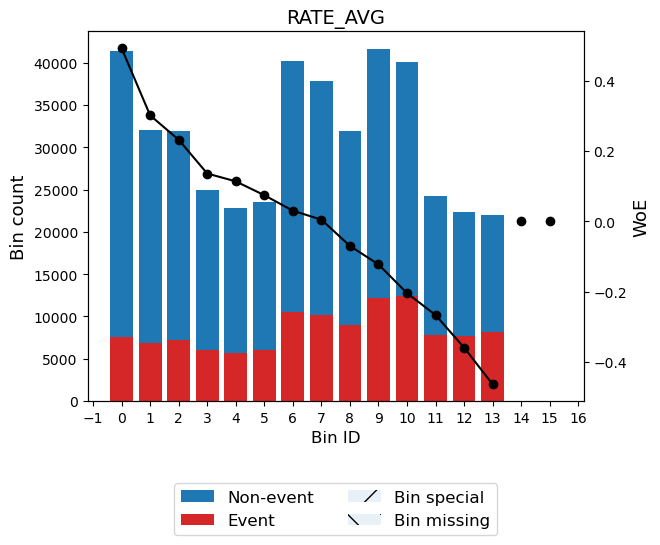


Processing: MAX_DPD_12M_OBS...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.50)",43566,0.10,43250,316,0.01,3.92,0.52,0.04
1,"[3.50, 6.50)",28626,0.07,28313,313,0.01,3.50,0.30,0.03
2,"[6.50, 9.50)",26664,0.06,26323,341,0.01,3.35,0.27,0.02
3,"[9.50, 13.50)",32213,0.07,30253,1960,0.06,1.74,0.14,0.02
4,"[13.50, 17.50)",28924,0.07,26629,2295,0.08,1.45,0.09,0.01
5,"[17.50, 22.50)",32083,0.07,28645,3438,0.11,1.12,0.07,0.01
6,"[22.50, 26.50)",23525,0.05,20312,3213,0.14,0.84,0.03,0.00
7,"[26.50, 35.50)",46423,0.11,37236,9187,0.20,0.40,0.02,0.00
8,"[35.50, 45.50)",43451,0.10,30180,13271,0.31,-0.18,0.00,0.00
9,"[45.50, 54.50)",33361,0.08,19099,14262,0.43,-0.71,0.04,0.01


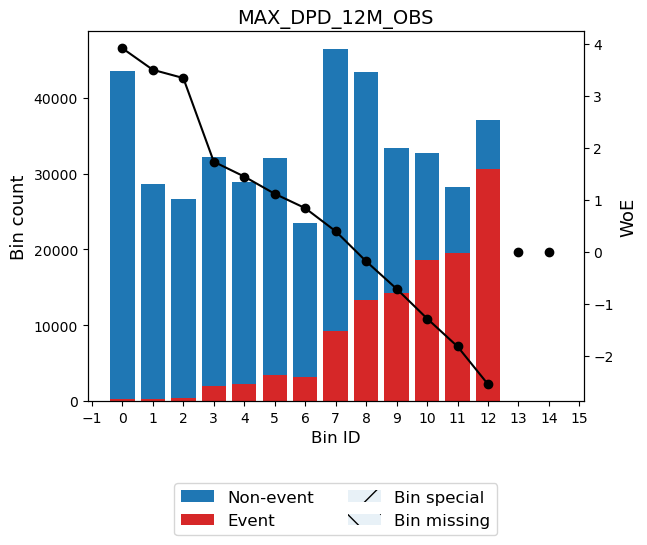

In [738]:
# ==========================================
# 14. WOE BINNING CHO PHÂN KHÚC "MASS UNSECURED"
# ==========================================
from optbinning import OptimalBinning
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu cho phân khúc Mass
target_segment = '3. Mass Unsecured'
df_model = df[df['SEGMENT'] == target_segment].copy()

X_model = df_model.drop(columns=['BAD_NEXT_12M', 'SEGMENT', 'SAMPLE_TYPE', 'SOCIF', 'year'])
y_model = df_model['BAD_NEXT_12M']

print(f"--- ĐANG XÂY DỰNG BINNING CHO: {target_segment} ---")
print(f"Số lượng mẫu: {len(df_model):,}")
print(f"Bad Rate: {y_model.mean():.2%}")

# 2. Chọn danh sách biến cần Binning (Lấy Top IV từ bước trước)
# Ta bỏ MAX_DPD ra để xử lý riêng (vì nó quá mạnh), tập trung vào các biến tài chính/hành vi khác
selected_features = [
    'N_AVG_DEPOSIT_12M', 'LTV', 'INCOME', 
    'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS'
]

binning_results = {}

# 3. Chạy vòng lặp Binning và Vẽ hình
for feature in selected_features:
    print(f"\nProcessing: {feature}...")
    
    # Cấu hình Binning
    # monotonic_trend='auto_asc_desc': Tự động tìm xu hướng tăng/giảm đơn điệu
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip", 
                          monotonic_trend="auto_asc_desc",
                          min_prebin_size=0.05) # Mỗi bin tối thiểu 5% dân số
    
    optb.fit(X_model[feature], y_model)
    
    # Lưu kết quả
    binning_results[feature] = optb
    
    # Hiển thị bảng WOE
    bin_table = optb.binning_table.build()
    display(bin_table.head(10))
    
    # Vẽ biểu đồ WOE (Rất quan trọng để check logic)
    #  -> Code dưới sẽ vẽ ra hình tương tự
    optb.binning_table.plot(metric="woe")


=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===
Transforming: N_AVG_DEPOSIT_12M...
Transforming: LTV...
Transforming: INCOME...
Transforming: CBAL_TO_INC_12MON...
Transforming: RATE_AVG...
Transforming: MAX_DPD_12M_OBS...
------------------------------
Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):


,N_AVG_DEPOSIT_12M,LTV,INCOME,CBAL_TO_INC_12MON,RATE_AVG,MAX_DPD_12M_OBS,BAD_NEXT_12M
0,-0.30,0.00,-0.06,-0.04,0.30,1.74,0
1,-0.43,0.00,-0.09,-0.13,-0.27,0.40,0
2,-0.18,0.00,-0.01,-0.04,0.11,0.84,1
3,0.84,0.00,-0.03,0.43,0.00,0.40,0
4,0.34,0.00,-0.03,-0.04,-0.12,-0.18,1



=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===


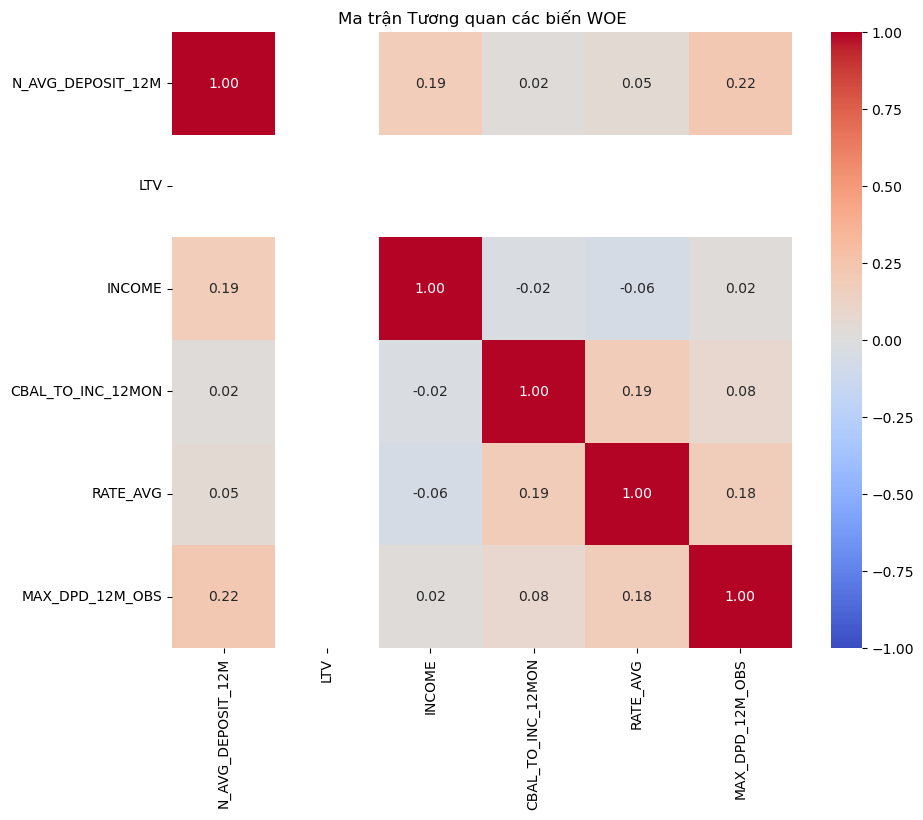

In [739]:
# ==========================================
# 15. TRANSFORMATION: CHUYỂN ĐỔI DỮ LIỆU SANG WOE
# ==========================================
print("\n=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===")

# Danh sách các biến đã chốt (Selected Features) cho mô hình Mass Unsecured
# (Đây là ví dụ, bạn có thể thêm bớt tùy vào kết quả IV/Binning của bước trước)
final_features = [
    'N_AVG_DEPOSIT_12M', 
    'LTV', 
    'INCOME', 
    'CBAL_TO_INC_12MON', 
    'RATE_AVG', 
    'MAX_DPD_12M_OBS'
]

# Tạo DataFrame mới để chứa giá trị WOE
X_woe = pd.DataFrame()
woe_models = {} # Lưu lại model binning để sau này dùng cho tập Test/OOT

for feature in final_features:
    print(f"Transforming: {feature}...")
    
    # Cấu hình Binning (dùng solver="mip" để tránh lỗi)
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip",
                          monotonic_trend="auto_asc_desc")
    
    # Fit và Transform
    optb.fit(X_model[feature], y_model)
    
    # Lưu giá trị WOE vào DataFrame mới
    X_woe[feature] = optb.transform(X_model[feature], metric="woe")
    
    # Lưu model lại
    woe_models[feature] = optb

# Thêm cột Target vào để tiện xử lý
X_woe['BAD_NEXT_12M'] = y_model.values

print("-" * 30)
print("Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):")
display(X_woe.head())

# ==========================================
# 16. KIỂM TRA TƯƠNG QUAN (MULTICOLLINEARITY)
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===")
# Mô hình Logistic Regression rất ghét các biến giống nhau (Tương quan cao)
# Nếu 2 biến có corr > 0.7, ta phải bỏ 1 biến.

corr = X_woe.drop(columns=['BAD_NEXT_12M']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Ma trận Tương quan các biến WOE")
plt.show()

In [740]:
# ==========================================
# 17. HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) - ĐÃ FIX LỖI INDEX
# ==========================================
import statsmodels.api as sm

print("\n=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===")

# 1. Loại bỏ LTV (Do bị hằng số trong phân khúc Mass Unsecured)
# Lưu ý: Kiểm tra kỹ tên cột trong X_woe xem có LTV không, nếu code trước đã drop hoặc chưa tạo thì lệnh này vẫn chạy ổn.
final_features_clean = [col for col in final_features if col != 'LTV']

print(f"Danh sách biến cuối cùng ({len(final_features_clean)} biến): {final_features_clean}")

# 2. Chuẩn bị dữ liệu & SỬA LỖI INDEX
# Reset index drop=True để cả X và y đều có index là 0, 1, 2, 3... khớp nhau 100%
X_train = X_woe[final_features_clean].reset_index(drop=True)
y_train = y_model.reset_index(drop=True)

# Thêm cột hằng số (Intercept/Bias)
X_train_const = sm.add_constant(X_train)

# 3. Fit mô hình Logistic Regression
try:
    logit_model = sm.Logit(y_train, X_train_const)
    result = logit_model.fit()
    
    # 4. Xuất báo cáo thống kê
    print(result.summary())
    
except Exception as e:
    print(f"Vẫn còn lỗi: {str(e)}")

# ==========================================
# 18. KIỂM TRA P-VALUE (SIGNIFICANCE)
# ==========================================
if 'result' in locals():
    print("\n--- ĐÁNH GIÁ CÁC BIẾN (P-VALUE CHECK) ---")
    p_values = result.pvalues
    
    # Lọc các biến có P-value cao (không có ý nghĩa thống kê)
    # Thường ngưỡng là 0.05
    high_p_value_vars = p_values[p_values >= 0.05]
    
    if len(high_p_value_vars) > 0:
        print("\nCẢNH BÁO: Các biến sau có P-value cao (cần xem xét loại bỏ):")
        print(high_p_value_vars)
    else:
        print("\nTUYỆT VỜI: Tất cả các biến đều có ý nghĩa thống kê (P < 0.05)!")


=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===
Danh sách biến cuối cùng (5 biến): ['N_AVG_DEPOSIT_12M', 'INCOME', 'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS']
Optimization terminated successfully.
         Current function value: 0.381333
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               436916
Model:                          Logit   Df Residuals:                   436910
Method:                           MLE   Df Model:                            5
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3447
Time:                        11:27:52   Log-Likelihood:            -1.6661e+05
converged:                       True   LL-Null:                   -2.5427e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [741]:
# ==========================================
# 19. CHẠY LẠI MÔ HÌNH (FINAL MODEL) & ĐÁNH GIÁ GINI
# ==========================================
from sklearn.metrics import roc_auc_score

print("\n=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===")

# 1. Chốt danh sách biến cuối cùng (Chỉ giữ lại biến P < 0.05)
# Bỏ 'INCOME' và 'RATE_AVG' và 'LTV'
final_vars_v2 = ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS']

print(f"Biến đưa vào mô hình: {final_vars_v2}")

# 2. Chuẩn bị dữ liệu (Reset index để tránh lỗi)
X_train_v2 = X_woe[final_vars_v2].reset_index(drop=True)
y_train_v2 = y_model.reset_index(drop=True)

X_train_const_v2 = sm.add_constant(X_train_v2)

# 3. Fit mô hình
logit_final = sm.Logit(y_train_v2, X_train_const_v2)
result_final = logit_final.fit()

print(result_final.summary())

# ==========================================
# 20. TÍNH GINI & KẾT LUẬN SỨC MẠNH MÔ HÌNH
# ==========================================
print("\n--- ĐÁNH GIÁ SỨC MẠNH MÔ HÌNH (PERFORMANCE) ---")

# Dự báo xác suất (Probability) trên tập Train
y_pred_prob = result_final.predict(X_train_const_v2)

# Tính AUC
auc = roc_auc_score(y_train_v2, y_pred_prob)

# Tính Gini (Công thức: Gini = 2*AUC - 1)
gini = 2 * auc - 1

print(f"-> AUC Score: {auc:.4f}")
print(f"-> GINI Coefficient: {gini:.4f}")

if gini > 0.4:
    print("=> ĐÁNH GIÁ: Mô hình TUYỆT VỜI (Excellent).")
elif gini > 0.3:
    print("=> ĐÁNH GIÁ: Mô hình TỐT (Good).")
else:
    print("=> ĐÁNH GIÁ: Mô hình TRUNG BÌNH/YẾU.")


=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===
Biến đưa vào mô hình: ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS']
Optimization terminated successfully.
         Current function value: 0.381334
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               436916
Model:                          Logit   Df Residuals:                   436912
Method:                           MLE   Df Model:                            3
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3447
Time:                        11:27:54   Log-Likelihood:            -1.6661e+05
converged:                       True   LL-Null:                   -2.5427e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

# 2. Prime Unsecured

--- ĐANG XÂY DỰNG BINNING CHO: 2. Prime Unsecured ---
Số lượng mẫu: 280,190
Bad Rate: 5.93%

Processing: N_AVG_DEPOSIT_12M...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3724033.50)",15404,0.05,13513,1891,0.12,-0.80,0.05,0.01
1,"[3724033.50, 4032118.50)",19138,0.07,16919,2219,0.12,-0.73,0.05,0.01
2,"[4032118.50, 4345168.50)",17496,0.06,15686,1810,0.10,-0.60,0.03,0.00
3,"[4345168.50, 4737440.00)",19006,0.07,17109,1897,0.10,-0.56,0.03,0.00
4,"[4737440.00, 5106656.00)",15949,0.06,14464,1485,0.09,-0.49,0.02,0.00
5,"[5106656.00, 5777220.00)",24875,0.09,23047,1828,0.07,-0.23,0.01,0.00
6,"[5777220.00, 6506055.00)",22158,0.08,20734,1424,0.06,-0.08,0.00,0.00
7,"[6506055.00, 7090925.00)",14653,0.05,13850,803,0.05,0.08,0.00,0.00
8,"[7090925.00, 8056072.00)",19785,0.07,18835,950,0.05,0.22,0.00,0.00
9,"[8056072.00, 8878372.50)",14010,0.05,13434,576,0.04,0.39,0.01,0.00


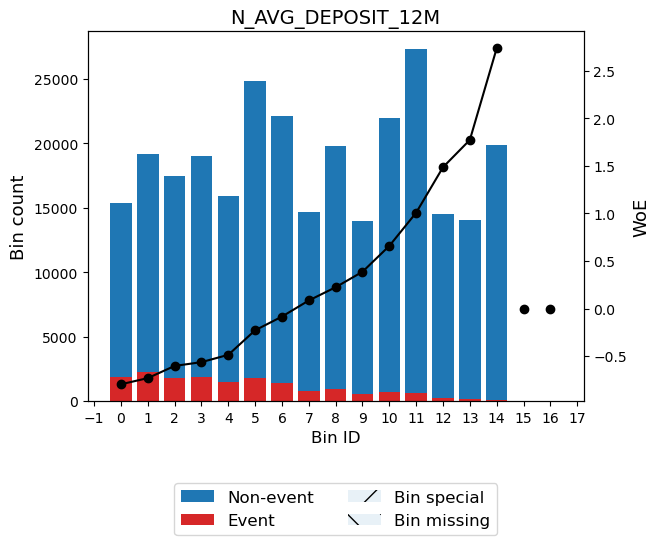


Processing: LTV...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",280190,1.00,263563,16627,0.06,0.00,0.00,0.00
1,Special,0,0.00,0,0,0.00,0.00,0.00,0.00
2,Missing,0,0.00,0,0,0.00,0.00,0.00,0.00
Totals,,280190,1.00,263563,16627,0.06,,0.00,0.00


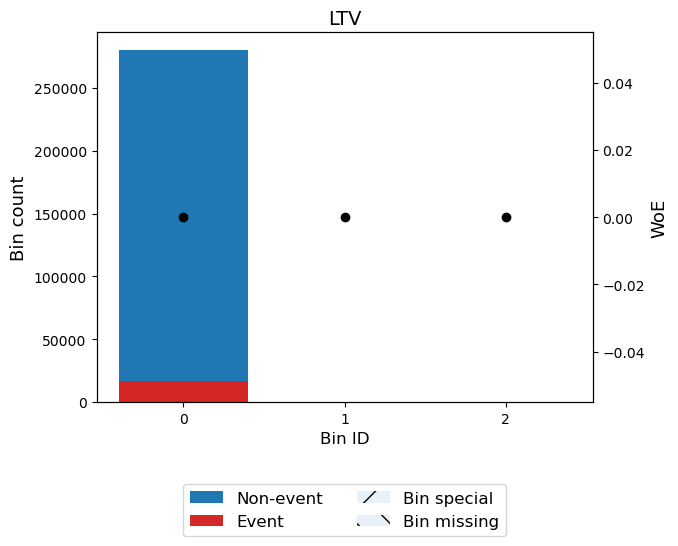


Processing: INCOME...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 17911419.00)",47501,0.17,44623,2878,0.06,-0.02,0.00,0.00
1,"[17911419.00, 30032296.00)",170305,0.61,160179,10126,0.06,-0.00,0.00,0.00
2,"[30032296.00, 38722448.00)",27154,0.10,25551,1603,0.06,0.01,0.00,0.00
3,"[38722448.00, inf)",35230,0.13,33210,2020,0.06,0.04,0.00,0.00
4,Special,0,0.00,0,0,0.00,0.00,0.00,0.00
5,Missing,0,0.00,0,0,0.00,0.00,0.00,0.00
Totals,,280190,1.00,263563,16627,0.06,,0.00,0.00


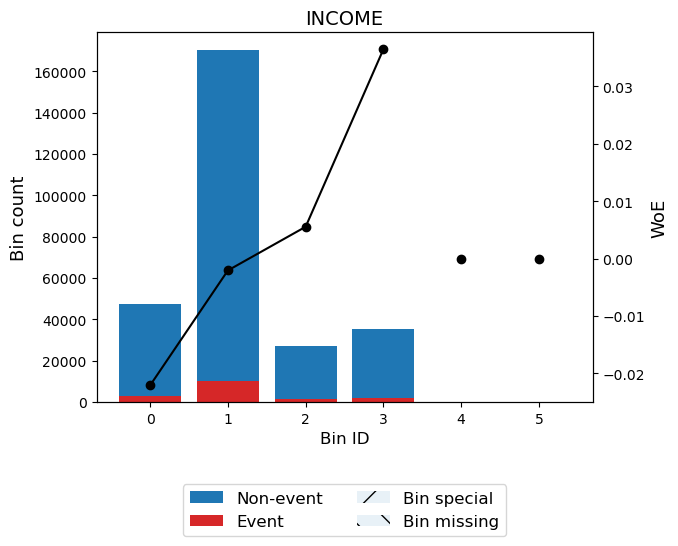


Processing: CBAL_TO_INC_12MON...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.61)",24821,0.09,24331,490,0.02,1.14,0.07,0.01
1,"[5.61, 7.13)",22950,0.08,22260,690,0.03,0.71,0.03,0.00
2,"[7.13, 8.21)",18035,0.06,17369,666,0.04,0.50,0.01,0.00
3,"[8.21, 9.45)",21375,0.08,20191,1184,0.06,0.07,0.00,0.00
4,"[9.45, 10.73)",21540,0.08,20307,1233,0.06,0.04,0.00,0.00
5,"[10.73, 13.01)",36339,0.13,34177,2162,0.06,-0.00,0.00,0.00
6,"[13.01, 14.38)",19893,0.07,18655,1238,0.06,-0.05,0.00,0.00
7,"[14.38, 17.46)",37509,0.13,34921,2588,0.07,-0.16,0.00,0.00
8,"[17.46, 20.26)",25971,0.09,24038,1933,0.07,-0.24,0.01,0.00
9,"[20.26, 22.44)",14846,0.05,13695,1151,0.08,-0.29,0.00,0.00


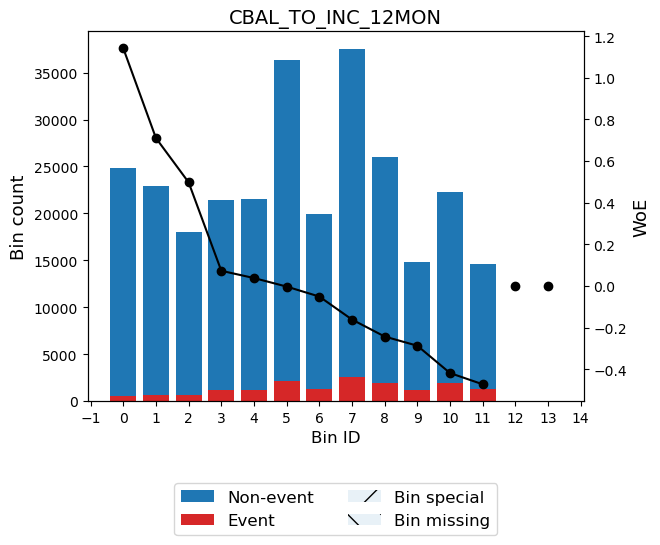


Processing: RATE_AVG...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.11)",25116,0.09,24748,368,0.01,1.45,0.10,0.01
1,"[5.11, 5.91)",23046,0.08,22507,539,0.02,0.97,0.05,0.01
2,"[5.91, 6.36)",17470,0.06,16951,519,0.03,0.72,0.02,0.00
3,"[6.36, 6.77)",18107,0.06,17455,652,0.04,0.52,0.01,0.00
4,"[6.77, 7.12)",17183,0.06,16495,688,0.04,0.41,0.01,0.00
5,"[7.12, 7.40)",14617,0.05,13957,660,0.05,0.29,0.00,0.00
6,"[7.40, 7.66)",14010,0.05,13362,648,0.05,0.26,0.00,0.00
7,"[7.66, 7.94)",15094,0.05,14340,754,0.05,0.18,0.00,0.00
8,"[7.94, 8.21)",14010,0.05,13283,727,0.05,0.14,0.00,0.00
9,"[8.21, 8.74)",27133,0.10,25490,1643,0.06,-0.02,0.00,0.00


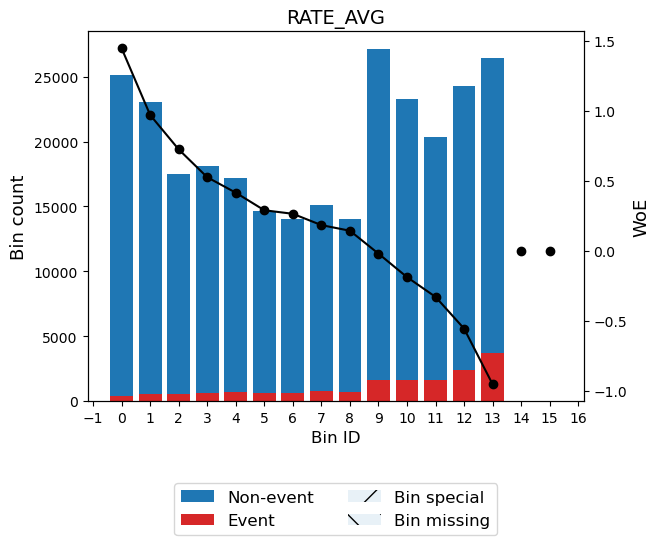


Processing: MAX_DPD_12M_OBS...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",31434,0.11,31377,57,0.00,3.55,0.41,0.03
1,"[0.50, 1.50)",24800,0.09,24748,52,0.00,3.40,0.31,0.03
2,"[1.50, 2.50)",20538,0.07,20479,59,0.00,3.09,0.23,0.02
3,"[2.50, 4.50)",31824,0.11,31709,115,0.00,2.86,0.32,0.03
4,"[4.50, 6.50)",24276,0.09,24172,104,0.00,2.69,0.23,0.02
5,"[6.50, 9.50)",27425,0.10,27283,142,0.01,2.49,0.24,0.02
6,"[9.50, 12.50)",20096,0.07,19606,490,0.02,0.93,0.04,0.01
7,"[12.50, 16.50)",19996,0.07,19305,691,0.03,0.57,0.02,0.00
8,"[16.50, 22.50)",20931,0.07,19883,1048,0.05,0.18,0.00,0.00
9,"[22.50, 33.50)",23472,0.08,21407,2065,0.09,-0.42,0.02,0.00


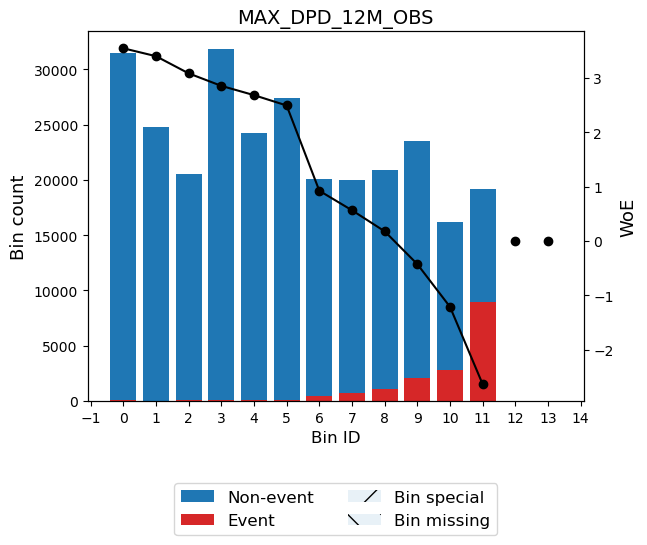

In [742]:
# ==========================================
# 14. WOE BINNING CHO PHÂN KHÚC "2. Prime Unsecured"
# ==========================================
from optbinning import OptimalBinning
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu cho phân khúc Mass
target_segment = '2. Prime Unsecured'
df_model = df[df['SEGMENT'] == target_segment].copy()

X_model = df_model.drop(columns=['BAD_NEXT_12M', 'SEGMENT', 'SAMPLE_TYPE', 'SOCIF', 'year'])
y_model = df_model['BAD_NEXT_12M']

print(f"--- ĐANG XÂY DỰNG BINNING CHO: {target_segment} ---")
print(f"Số lượng mẫu: {len(df_model):,}")
print(f"Bad Rate: {y_model.mean():.2%}")

# 2. Chọn danh sách biến cần Binning (Lấy Top IV từ bước trước)
# Ta bỏ MAX_DPD ra để xử lý riêng (vì nó quá mạnh), tập trung vào các biến tài chính/hành vi khác
selected_features = [
    'N_AVG_DEPOSIT_12M', 'LTV', 'INCOME', 
    'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS'
]

binning_results = {}

# 3. Chạy vòng lặp Binning và Vẽ hình
for feature in selected_features:
    print(f"\nProcessing: {feature}...")
    
    # Cấu hình Binning
    # monotonic_trend='auto_asc_desc': Tự động tìm xu hướng tăng/giảm đơn điệu
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip", 
                          monotonic_trend="auto_asc_desc",
                          min_prebin_size=0.05) # Mỗi bin tối thiểu 5% dân số
    
    optb.fit(X_model[feature], y_model)
    
    # Lưu kết quả
    binning_results[feature] = optb
    
    # Hiển thị bảng WOE
    bin_table = optb.binning_table.build()
    display(bin_table.head(10))
    
    # Vẽ biểu đồ WOE (Rất quan trọng để check logic)
    #  -> Code dưới sẽ vẽ ra hình tương tự
    optb.binning_table.plot(metric="woe")


=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===
Transforming: N_AVG_DEPOSIT_12M...
Transforming: LTV...
Transforming: INCOME...
Transforming: CBAL_TO_INC_12MON...
Transforming: RATE_AVG...
Transforming: MAX_DPD_12M_OBS...
------------------------------
Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):


,N_AVG_DEPOSIT_12M,LTV,INCOME,CBAL_TO_INC_12MON,RATE_AVG,MAX_DPD_12M_OBS,BAD_NEXT_12M
0,-0.49,0.00,-0.02,-0.42,-0.95,0.18,0
1,-0.49,0.00,-0.02,-0.00,0.72,0.18,0
2,0.66,0.00,-0.00,-0.05,-0.02,-0.42,0
3,-0.60,0.00,-0.02,-0.00,0.14,0.18,0
4,-0.73,0.00,-0.02,-0.29,0.26,-1.21,0



=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===


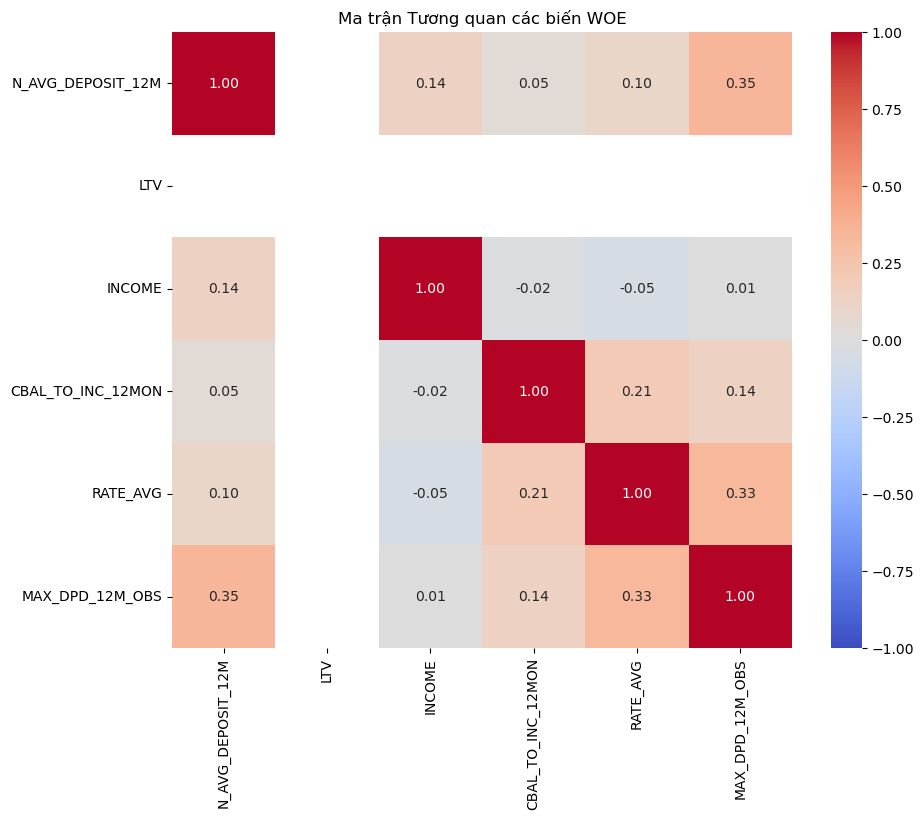

In [743]:
# ==========================================
# 15. TRANSFORMATION: CHUYỂN ĐỔI DỮ LIỆU SANG WOE
# ==========================================
print("\n=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===")

# Danh sách các biến đã chốt (Selected Features) cho mô hình 2. Prime Unsecured
# (Đây là ví dụ, bạn có thể thêm bớt tùy vào kết quả IV/Binning của bước trước)
final_features = [
    'N_AVG_DEPOSIT_12M', 
    'LTV', 
    'INCOME', 
    'CBAL_TO_INC_12MON', 
    'RATE_AVG', 
    'MAX_DPD_12M_OBS'
]

# Tạo DataFrame mới để chứa giá trị WOE
X_woe = pd.DataFrame()
woe_models = {} # Lưu lại model binning để sau này dùng cho tập Test/OOT

for feature in final_features:
    print(f"Transforming: {feature}...")
    
    # Cấu hình Binning (dùng solver="mip" để tránh lỗi)
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip",
                          monotonic_trend="auto_asc_desc")
    
    # Fit và Transform
    optb.fit(X_model[feature], y_model)
    
    # Lưu giá trị WOE vào DataFrame mới
    X_woe[feature] = optb.transform(X_model[feature], metric="woe")
    
    # Lưu model lại
    woe_models[feature] = optb

# Thêm cột Target vào để tiện xử lý
X_woe['BAD_NEXT_12M'] = y_model.values

print("-" * 30)
print("Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):")
display(X_woe.head())

# ==========================================
# 16. KIỂM TRA TƯƠNG QUAN (MULTICOLLINEARITY)
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===")
# Mô hình Logistic Regression rất ghét các biến giống nhau (Tương quan cao)
# Nếu 2 biến có corr > 0.7, ta phải bỏ 1 biến.

corr = X_woe.drop(columns=['BAD_NEXT_12M']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Ma trận Tương quan các biến WOE")
plt.show()

In [744]:
# ==========================================
# 17. HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) - ĐÃ FIX LỖI INDEX
# ==========================================
import statsmodels.api as sm

print("\n=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===")

# 1. Loại bỏ LTV (Do bị hằng số trong phân khúc 2. Prime Unsecured)
# Lưu ý: Kiểm tra kỹ tên cột trong X_woe xem có LTV không, nếu code trước đã drop hoặc chưa tạo thì lệnh này vẫn chạy ổn.
final_features_clean = [col for col in final_features if col != 'LTV']

print(f"Danh sách biến cuối cùng ({len(final_features_clean)} biến): {final_features_clean}")

# 2. Chuẩn bị dữ liệu & SỬA LỖI INDEX
# Reset index drop=True để cả X và y đều có index là 0, 1, 2, 3... khớp nhau 100%
X_train = X_woe[final_features_clean].reset_index(drop=True)
y_train = y_model.reset_index(drop=True)

# Thêm cột hằng số (Intercept/Bias)
X_train_const = sm.add_constant(X_train)

# 3. Fit mô hình Logistic Regression
try:
    logit_model = sm.Logit(y_train, X_train_const)
    result = logit_model.fit()
    
    # 4. Xuất báo cáo thống kê
    print(result.summary())
    
except Exception as e:
    print(f"Vẫn còn lỗi: {str(e)}")

# ==========================================
# 18. KIỂM TRA P-VALUE (SIGNIFICANCE)
# ==========================================
if 'result' in locals():
    print("\n--- ĐÁNH GIÁ CÁC BIẾN (P-VALUE CHECK) ---")
    p_values = result.pvalues
    
    # Lọc các biến có P-value cao (không có ý nghĩa thống kê)
    # Thường ngưỡng là 0.05
    high_p_value_vars = p_values[p_values >= 0.05]
    
    if len(high_p_value_vars) > 0:
        print("\nCẢNH BÁO: Các biến sau có P-value cao (cần xem xét loại bỏ):")
        print(high_p_value_vars)
    else:
        print("\nTUYỆT VỜI: Tất cả các biến đều có ý nghĩa thống kê (P < 0.05)!")


=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===
Danh sách biến cuối cùng (5 biến): ['N_AVG_DEPOSIT_12M', 'INCOME', 'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS']
Optimization terminated successfully.
         Current function value: 0.143769
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               280190
Model:                          Logit   Df Residuals:                   280184
Method:                           MLE   Df Model:                            5
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3615
Time:                        11:28:03   Log-Likelihood:                -40283.
converged:                       True   LL-Null:                       -63086.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [745]:
# ==========================================
# 19. CHẠY LẠI MÔ HÌNH (FINAL MODEL) & ĐÁNH GIÁ GINI
# ==========================================
from sklearn.metrics import roc_auc_score

print("\n=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===")

# 1. Chốt danh sách biến cuối cùng (Chỉ giữ lại biến P < 0.05)
# Bỏ 'INCOME' và 'RATE_AVG' và 'LTV'
final_vars_v2 = ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS', 'RATE_AVG']

print(f"Biến đưa vào mô hình: {final_vars_v2}")

# 2. Chuẩn bị dữ liệu (Reset index để tránh lỗi)
X_train_v2 = X_woe[final_vars_v2].reset_index(drop=True)
y_train_v2 = y_model.reset_index(drop=True)

X_train_const_v2 = sm.add_constant(X_train_v2)

# 3. Fit mô hình
logit_final = sm.Logit(y_train_v2, X_train_const_v2)
result_final = logit_final.fit()

print(result_final.summary())

# ==========================================
# 20. TÍNH GINI & KẾT LUẬN SỨC MẠNH MÔ HÌNH
# ==========================================
print("\n--- ĐÁNH GIÁ SỨC MẠNH MÔ HÌNH (PERFORMANCE) ---")

# Dự báo xác suất (Probability) trên tập Train
y_pred_prob = result_final.predict(X_train_const_v2)

# Tính AUC
auc = roc_auc_score(y_train_v2, y_pred_prob)

# Tính Gini (Công thức: Gini = 2*AUC - 1)
gini = 2 * auc - 1

print(f"-> AUC Score: {auc:.4f}")
print(f"-> GINI Coefficient: {gini:.4f}")

if gini > 0.4:
    print("=> ĐÁNH GIÁ: Mô hình TUYỆT VỜI (Excellent).")
elif gini > 0.3:
    print("=> ĐÁNH GIÁ: Mô hình TỐT (Good).")
else:
    print("=> ĐÁNH GIÁ: Mô hình TRUNG BÌNH/YẾU.")


=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===
Biến đưa vào mô hình: ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS', 'RATE_AVG']
Optimization terminated successfully.
         Current function value: 0.143773
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               280190
Model:                          Logit   Df Residuals:                   280185
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3614
Time:                        11:28:05   Log-Likelihood:                -40284.
converged:                       True   LL-Null:                       -63086.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

# 1. Rich/Secured

--- ĐANG XÂY DỰNG BINNING CHO: 1. Rich/Secured ---
Số lượng mẫu: 421,221
Bad Rate: 0.72%

Processing: N_AVG_DEPOSIT_12M...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 605518.50)",25243,0.06,24418,825,0.03,-1.54,0.33,0.04
1,"[605518.50, 914035.50)",24570,0.06,24122,448,0.02,-0.95,0.09,0.01
2,"[914035.50, 1201045.50)",23693,0.06,23348,345,0.01,-0.72,0.04,0.01
3,"[1201045.50, 1552191.50)",28292,0.07,27971,321,0.01,-0.46,0.02,0.00
4,"[1552191.50, 1900926.50)",25992,0.06,25743,249,0.01,-0.29,0.01,0.00
5,"[1900926.50, 2533498.00)",40425,0.10,40115,310,0.01,-0.07,0.00,0.00
6,"[2533498.00, 3640869.00)",54077,0.13,53810,267,0.00,0.37,0.02,0.00
7,"[3640869.00, 4733793.00)",38840,0.09,38717,123,0.00,0.82,0.04,0.01
8,"[4733793.00, 5766376.50)",27111,0.06,27058,53,0.00,1.30,0.06,0.01
9,"[5766376.50, 7701487.50)",35255,0.08,35203,52,0.00,1.59,0.11,0.01


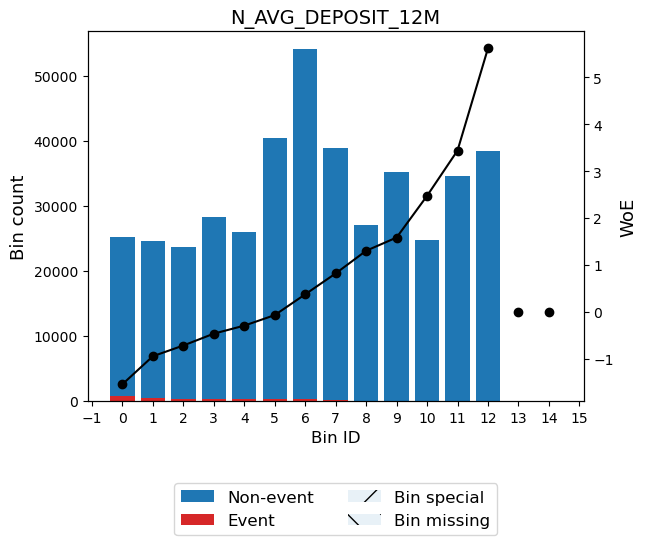


Processing: LTV...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.12)",22120,0.05,22083,37,0.00,1.46,0.06,0.01
1,"[5.12, 7.44)",37860,0.09,37751,109,0.00,0.92,0.05,0.01
2,"[7.44, 9.53)",41959,0.10,41772,187,0.00,0.48,0.02,0.00
3,"[9.53, 10.80)",25931,0.06,25805,126,0.00,0.39,0.01,0.00
4,"[10.80, 11.87)",21549,0.05,21435,114,0.01,0.30,0.00,0.00
5,"[11.87, 14.06)",42140,0.10,41874,266,0.01,0.13,0.00,0.00
6,"[14.06, 16.31)",38663,0.09,38398,265,0.01,0.04,0.00,0.00
7,"[16.31, 19.76)",48728,0.12,48371,357,0.01,-0.02,0.00,0.00
8,"[19.76, 21.77)",23173,0.06,22988,185,0.01,-0.11,0.00,0.00
9,"[21.77, 26.14)",38236,0.09,37898,338,0.01,-0.21,0.00,0.00


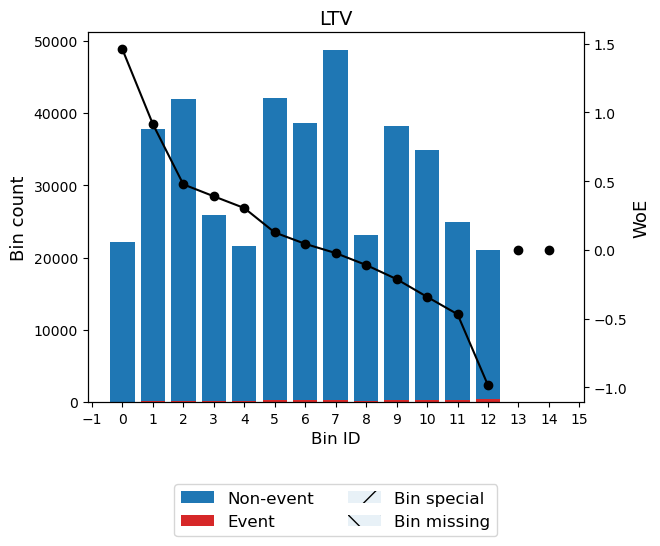


Processing: INCOME...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 34716550.00)",362043,0.86,359571,2472,0.01,0.05,0.00,0.00
1,"[34716550.00, 46264938.00)",37969,0.09,37647,322,0.01,-0.17,0.00,0.00
2,"[46264938.00, inf)",21209,0.05,20986,223,0.01,-0.39,0.01,0.00
3,Special,0,0.00,0,0,0.00,0.00,0.00,0.00
4,Missing,0,0.00,0,0,0.00,0.00,0.00,0.00
Totals,,421221,1.00,418204,3017,0.01,,0.01,0.00


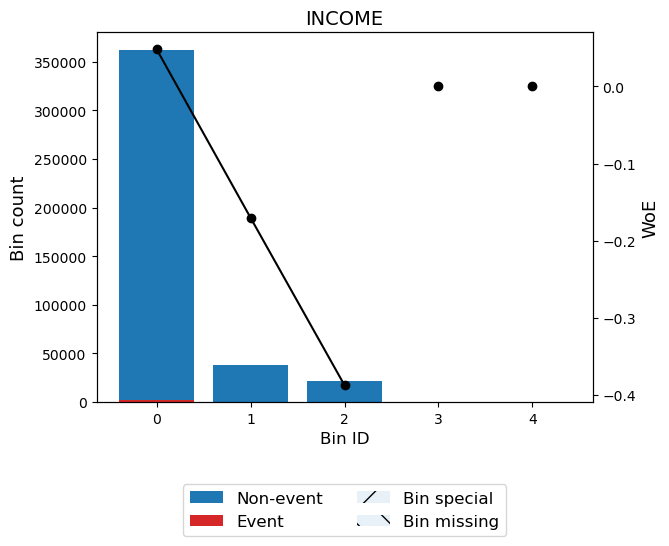


Processing: CBAL_TO_INC_12MON...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.36)",27747,0.07,27708,39,0.00,1.63,0.09,0.01
1,"[5.36, 7.01)",33409,0.08,33347,62,0.00,1.36,0.08,0.01
2,"[7.01, 8.08)",25617,0.06,25543,74,0.00,0.91,0.03,0.00
3,"[8.08, 9.00)",22826,0.05,22724,102,0.00,0.47,0.01,0.00
4,"[9.00, 10.68)",42419,0.10,42174,245,0.01,0.22,0.00,0.00
5,"[10.68, 12.88)",52002,0.12,51699,303,0.01,0.21,0.00,0.00
6,"[12.88, 13.82)",21134,0.05,21002,132,0.01,0.14,0.00,0.00
7,"[13.82, 15.20)",28694,0.07,28484,210,0.01,-0.02,0.00,0.00
8,"[15.20, 18.48)",57204,0.14,56760,444,0.01,-0.08,0.00,0.00
9,"[18.48, 20.84)",31571,0.07,31251,320,0.01,-0.35,0.01,0.00


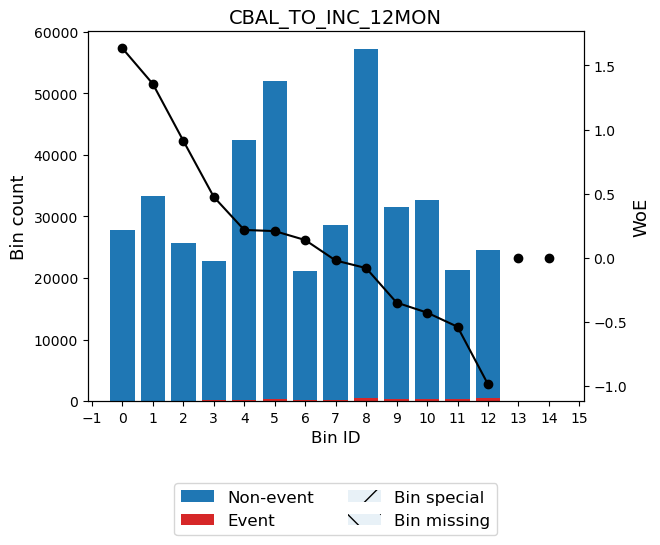


Processing: RATE_AVG...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.13)",29584,0.07,29510,74,0.00,1.06,0.05,0.01
1,"[5.13, 6.00)",32959,0.08,32843,116,0.00,0.71,0.03,0.00
2,"[6.00, 7.00)",58579,0.14,58314,265,0.00,0.46,0.02,0.00
3,"[7.00, 7.46)",33332,0.08,33166,166,0.00,0.37,0.01,0.00
4,"[7.46, 8.03)",43880,0.10,43617,263,0.01,0.18,0.00,0.00
5,"[8.03, 8.34)",24841,0.06,24688,153,0.01,0.15,0.00,0.00
6,"[8.34, 9.14)",60057,0.14,59638,419,0.01,0.03,0.00,0.00
7,"[9.14, 9.54)",26916,0.06,26700,216,0.01,-0.11,0.00,0.00
8,"[9.54, 10.50)",50893,0.12,50392,501,0.01,-0.32,0.01,0.00
9,"[10.50, 11.72)",37333,0.09,36892,441,0.01,-0.51,0.03,0.00


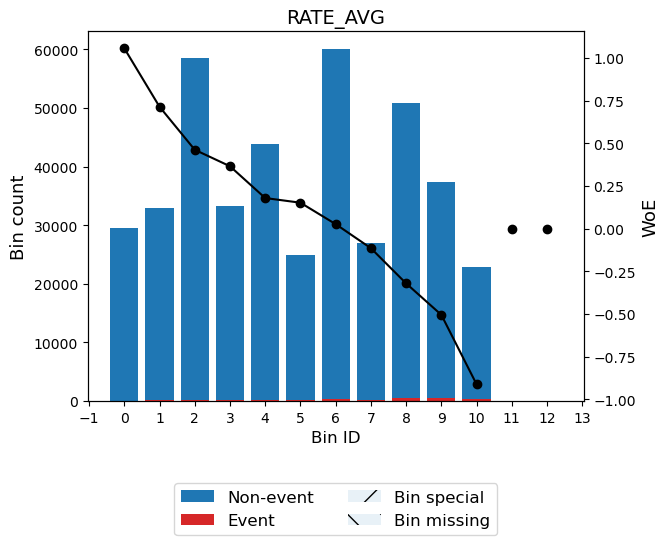


Processing: MAX_DPD_12M_OBS...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",36179,0.09,36178,1,0.00,5.56,0.48,0.03
1,"[0.50, 3.50)",65367,0.16,65365,2,0.00,5.46,0.85,0.05
2,"[3.50, 11.50)",92229,0.22,92222,7,0.00,4.55,0.99,0.07
3,"[11.50, 16.50)",36352,0.09,36337,15,0.00,2.86,0.23,0.02
4,"[16.50, 22.50)",33485,0.08,33465,20,0.00,2.49,0.18,0.02
5,"[22.50, 27.50)",22251,0.05,22233,18,0.00,2.19,0.10,0.01
6,"[27.50, 34.50)",25942,0.06,25892,50,0.00,1.32,0.06,0.01
7,"[34.50, 42.50)",24223,0.06,24155,68,0.00,0.94,0.03,0.00
8,"[42.50, 54.50)",28847,0.07,28637,210,0.01,-0.02,0.00,0.00
9,"[54.50, 71.50)",31066,0.07,30354,712,0.02,-1.18,0.19,0.02


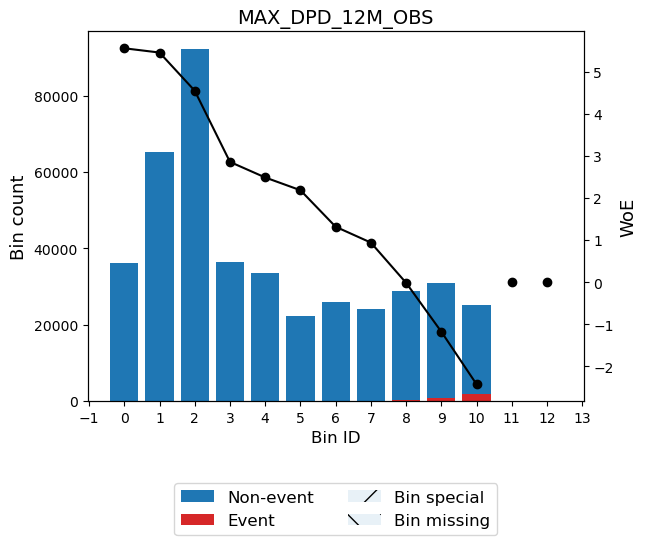

In [746]:
# ==========================================
# 14. WOE BINNING CHO PHÂN KHÚC "3. Rich/Secured"
# ==========================================
from optbinning import OptimalBinning
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu cho phân khúc Mass
target_segment = '1. Rich/Secured'
df_model = df[df['SEGMENT'] == target_segment].copy()

X_model = df_model.drop(columns=['BAD_NEXT_12M', 'SEGMENT', 'SAMPLE_TYPE', 'SOCIF', 'year'])
y_model = df_model['BAD_NEXT_12M']

print(f"--- ĐANG XÂY DỰNG BINNING CHO: {target_segment} ---")
print(f"Số lượng mẫu: {len(df_model):,}")
print(f"Bad Rate: {y_model.mean():.2%}")

# 2. Chọn danh sách biến cần Binning (Lấy Top IV từ bước trước)
# Ta bỏ MAX_DPD ra để xử lý riêng (vì nó quá mạnh), tập trung vào các biến tài chính/hành vi khác
selected_features = [
    'N_AVG_DEPOSIT_12M', 'LTV', 'INCOME', 
    'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS'
]

binning_results = {}

# 3. Chạy vòng lặp Binning và Vẽ hình
for feature in selected_features:
    print(f"\nProcessing: {feature}...")
    
    # Cấu hình Binning
    # monotonic_trend='auto_asc_desc': Tự động tìm xu hướng tăng/giảm đơn điệu
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip", 
                          monotonic_trend="auto_asc_desc",
                          min_prebin_size=0.05) # Mỗi bin tối thiểu 5% dân số
    
    optb.fit(X_model[feature], y_model)
    
    # Lưu kết quả
    binning_results[feature] = optb
    
    # Hiển thị bảng WOE
    bin_table = optb.binning_table.build()
    display(bin_table.head(10))
    
    # Vẽ biểu đồ WOE (Rất quan trọng để check logic)
    #  -> Code dưới sẽ vẽ ra hình tương tự
    optb.binning_table.plot(metric="woe")



=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===
Transforming: N_AVG_DEPOSIT_12M...
Transforming: LTV...
Transforming: INCOME...
Transforming: CBAL_TO_INC_12MON...
Transforming: RATE_AVG...
Transforming: MAX_DPD_12M_OBS...
------------------------------
Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):


,N_AVG_DEPOSIT_12M,LTV,INCOME,CBAL_TO_INC_12MON,RATE_AVG,MAX_DPD_12M_OBS,BAD_NEXT_12M
0,0.37,0.92,0.05,1.36,0.37,5.46,0
1,-0.29,0.04,0.05,0.22,-0.51,0.94,0
2,-1.54,0.92,0.05,0.22,0.18,4.55,0
3,-0.46,0.39,0.05,0.21,1.06,2.19,0
4,0.37,1.46,0.05,1.63,1.06,0.94,0



=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===


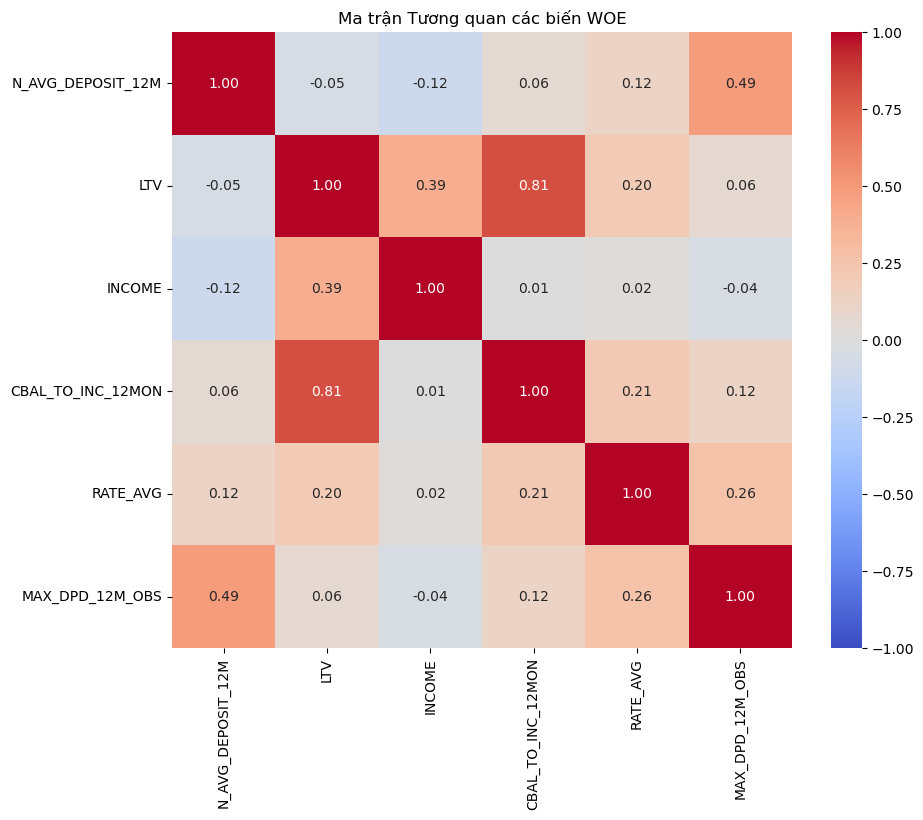

In [747]:
# ==========================================
# 15. TRANSFORMATION: CHUYỂN ĐỔI DỮ LIỆU SANG WOE
# ==========================================
print("\n=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===")

# Danh sách các biến đã chốt (Selected Features) cho mô hình 2. Rich/Secured
# (Đây là ví dụ, bạn có thể thêm bớt tùy vào kết quả IV/Binning của bước trước)
final_features = [
    'N_AVG_DEPOSIT_12M', 
    'LTV', 
    'INCOME', 
    'CBAL_TO_INC_12MON', 
    'RATE_AVG', 
    'MAX_DPD_12M_OBS'
]

# Tạo DataFrame mới để chứa giá trị WOE
X_woe = pd.DataFrame()
woe_models = {} # Lưu lại model binning để sau này dùng cho tập Test/OOT

for feature in final_features:
    print(f"Transforming: {feature}...")
    
    # Cấu hình Binning (dùng solver="mip" để tránh lỗi)
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip",
                          monotonic_trend="auto_asc_desc")
    
    # Fit và Transform
    optb.fit(X_model[feature], y_model)
    
    # Lưu giá trị WOE vào DataFrame mới
    X_woe[feature] = optb.transform(X_model[feature], metric="woe")
    
    # Lưu model lại
    woe_models[feature] = optb

# Thêm cột Target vào để tiện xử lý
X_woe['BAD_NEXT_12M'] = y_model.values

print("-" * 30)
print("Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):")
display(X_woe.head())

# ==========================================
# 16. KIỂM TRA TƯƠNG QUAN (MULTICOLLINEARITY)
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===")
# Mô hình Logistic Regression rất ghét các biến giống nhau (Tương quan cao)
# Nếu 2 biến có corr > 0.7, ta phải bỏ 1 biến.

corr = X_woe.drop(columns=['BAD_NEXT_12M']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Ma trận Tương quan các biến WOE")
plt.show()

In [748]:
# ==========================================
# 17. HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) - ĐÃ FIX LỖI INDEX
# ==========================================
import statsmodels.api as sm

print("\n=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===")

# 1. Loại bỏ LTV (Do bị hằng số trong phân khúc 2. Rich/Secured)
# Lưu ý: Kiểm tra kỹ tên cột trong X_woe xem có LTV không, nếu code trước đã drop hoặc chưa tạo thì lệnh này vẫn chạy ổn.
final_features_clean = [col for col in final_features if col != 'LTV']

print(f"Danh sách biến cuối cùng ({len(final_features_clean)} biến): {final_features_clean}")

# 2. Chuẩn bị dữ liệu & SỬA LỖI INDEX
# Reset index drop=True để cả X và y đều có index là 0, 1, 2, 3... khớp nhau 100%
X_train = X_woe[final_features_clean].reset_index(drop=True)
y_train = y_model.reset_index(drop=True)

# Thêm cột hằng số (Intercept/Bias)
X_train_const = sm.add_constant(X_train)

# 3. Fit mô hình Logistic Regression
try:
    logit_model = sm.Logit(y_train, X_train_const)
    result = logit_model.fit()
    
    # 4. Xuất báo cáo thống kê
    print(result.summary())
    
except Exception as e:
    print(f"Vẫn còn lỗi: {str(e)}")

# ==========================================
# 18. KIỂM TRA P-VALUE (SIGNIFICANCE)
# ==========================================
if 'result' in locals():
    print("\n--- ĐÁNH GIÁ CÁC BIẾN (P-VALUE CHECK) ---")
    p_values = result.pvalues
    
    # Lọc các biến có P-value cao (không có ý nghĩa thống kê)
    # Thường ngưỡng là 0.05
    high_p_value_vars = p_values[p_values >= 0.05]
    
    if len(high_p_value_vars) > 0:
        print("\nCẢNH BÁO: Các biến sau có P-value cao (cần xem xét loại bỏ):")
        print(high_p_value_vars)
    else:
        print("\nTUYỆT VỜI: Tất cả các biến đều có ý nghĩa thống kê (P < 0.05)!")


=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===
Danh sách biến cuối cùng (5 biến): ['N_AVG_DEPOSIT_12M', 'INCOME', 'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS']
Optimization terminated successfully.
         Current function value: 0.028968
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               421221
Model:                          Logit   Df Residuals:                   421215
Method:                           MLE   Df Model:                            5
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3186
Time:                        11:28:22   Log-Likelihood:                -12202.
converged:                       True   LL-Null:                       -17907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
----------

In [749]:
# ==========================================
# 19. CHẠY LẠI MÔ HÌNH (FINAL MODEL) & ĐÁNH GIÁ GINI
# ==========================================
from sklearn.metrics import roc_auc_score

print("\n=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===")

# 1. Chốt danh sách biến cuối cùng (Chỉ giữ lại biến P < 0.05)
# Bỏ 'INCOME' và 'RATE_AVG' và 'LTV'
final_vars_v2 = ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS', 'INCOME', 'RATE_AVG', 'LTV']

print(f"Biến đưa vào mô hình: {final_vars_v2}")

# 2. Chuẩn bị dữ liệu (Reset index để tránh lỗi)
X_train_v2 = X_woe[final_vars_v2].reset_index(drop=True)
y_train_v2 = y_model.reset_index(drop=True)

X_train_const_v2 = sm.add_constant(X_train_v2)

# 3. Fit mô hình
logit_final = sm.Logit(y_train_v2, X_train_const_v2)
result_final = logit_final.fit()

print(result_final.summary())

# ==========================================
# 20. TÍNH GINI & KẾT LUẬN SỨC MẠNH MÔ HÌNH
# ==========================================
print("\n--- ĐÁNH GIÁ SỨC MẠNH MÔ HÌNH (PERFORMANCE) ---")

# Dự báo xác suất (Probability) trên tập Train
y_pred_prob = result_final.predict(X_train_const_v2)

# Tính AUC
auc = roc_auc_score(y_train_v2, y_pred_prob)

# Tính Gini (Công thức: Gini = 2*AUC - 1)
gini = 2 * auc - 1

print(f"-> AUC Score: {auc:.4f}")
print(f"-> GINI Coefficient: {gini:.4f}")

if gini > 0.4:
    print("=> ĐÁNH GIÁ: Mô hình TUYỆT VỜI (Excellent).")
elif gini > 0.3:
    print("=> ĐÁNH GIÁ: Mô hình TỐT (Good).")
else:
    print("=> ĐÁNH GIÁ: Mô hình TRUNG BÌNH/YẾU.")


=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===
Biến đưa vào mô hình: ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS', 'INCOME', 'RATE_AVG', 'LTV']
Optimization terminated successfully.
         Current function value: 0.028932
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               421221
Model:                          Logit   Df Residuals:                   421214
Method:                           MLE   Df Model:                            6
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3194
Time:                        11:28:24   Log-Likelihood:                -12187.
converged:                       True   LL-Null:                       -17907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
--------